# Import packages

In [ ]:
import pandas as pd
import numpy as np
import random as r
import matplotlib.pyplot as plt
from zipfile import ZipFile
from sklearn.preprocessing import OneHotEncoder, KBinsDiscretizer
from sklearn.metrics import pairwise_distances
from sklearn.cluster import AgglomerativeClustering

# Load Data

In [ ]:
# specifying the zip file name 
file_name = "data-science-for-good-kiva-crowdfunding.zip"
  
# opening the zip file in READ mode 
with ZipFile(file_name, 'r') as zip: 
    # printing all the contents of the zip file 
    zip.printdir() 
  
    # extracting all the files 
    print('Extracting all the files now...') 
    zip.extractall() 
    print('Done!') 

In [ ]:
loans = pd.read_csv('kiva_loans.csv', sep=',', header = 0)
mpi = pd.read_csv('kiva_mpi_region_locations.csv', sep=',', header= 0).dropna()

In [ ]:
len(loans)

671205

# Descriptive Analysis

In [ ]:
# Plot the country's fraction of loans vs. its MPI index.
mpi_mean = mpi.groupby('country')['MPI'].mean()
mpi_mean = pd.DataFrame(mpi_mean)
loans_count = pd.DataFrame(loans.groupby('country')['id'].count()/len(loans)*100)
loans_mpi = loans_count.join(mpi_mean, on='country').dropna()

plt.plot(np.array(loans_mpi['MPI']), np.array(loans_mpi['id']),'o')
plt.xlabel('MPI', fontsize=12)
plt.ylabel('Percentage of the Total Loans (%)',fontsize=10)
plt.savefig("percentage_MPI.png")

In [ ]:
# Plot the faction of loans of different sectors
loans_sector = loans.groupby('sector')['id'].count()/len(loans)*100
loans_sector = pd.DataFrame(loans_sector)
loans_sector = loans_sector.reset_index('sector')

loans_sector = loans_sector.sort_values(by='id', ascending=False)
#plt.figure(figsize=(12,11))
plt.bar(loans_sector['sector'], loans_sector['id'])
plt.xticks(rotation = 75, fontsize=12)
plt.ylabel('Percentage of the Total Loans (%)',fontsize=10)
plt.savefig("sector_percentage.png", bbox_inches = "tight")

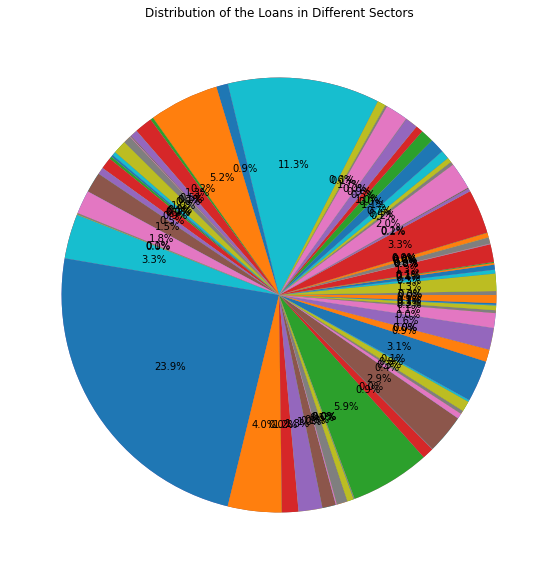

In [ ]:
loans_country = pd.DataFrame(loans.groupby('country_code')['id'].count()/len(loans)*100)
loans_country = loans_country.reset_index('country_code')
#loans_country = loans.sort_values(by='id', ascending=False)
#plt.figure(figsize=(12,11))
plt.figure(figsize=(10,10))
plt.pie(loans_country['id'], textprops={'fontsize': 50})
values = loans_country['id']
labels = loans_country['country_code']
plt.pie(values, autopct='%1.1f%%')
#plt.legend(labels,bbox_to_anchor=(1.2,0.5), loc="right", fontsize=12)
plt.title("Distribution of the Loans in Different Sectors")
plt.savefig("sector_pie.png")

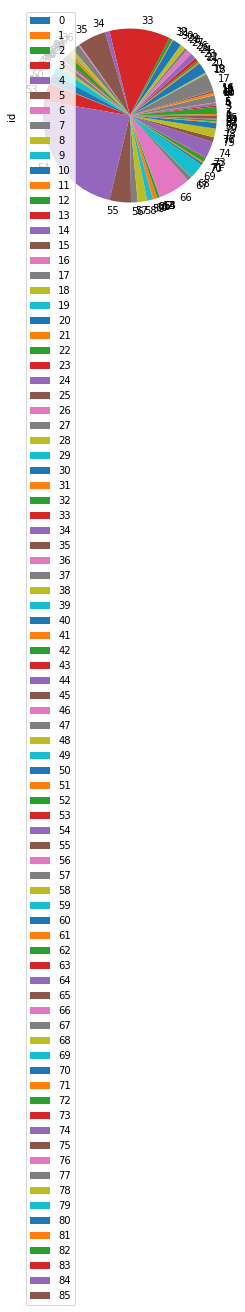

In [ ]:
loans_country.plot.pie(y='id')

In [ ]:
loans_country.head(3)

,country_code,id
0,AF,0.000298
1,AL,0.288138
2,AM,1.285896


In [ ]:
loans_country = loans_country.reset_index('country_code')
loans_country = loans_country.sort_values(by='id', ascending=False)

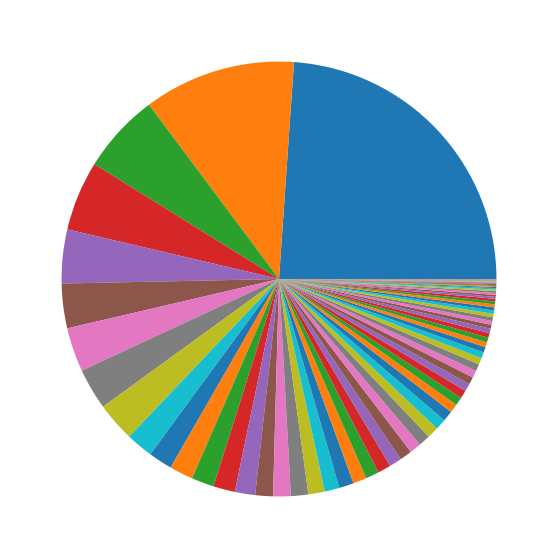

In [ ]:
plt.figure(figsize=(10,10))
plt.pie(loans_country['id'])
values = loans_country['id']
plt.savefig("country_pie.png")

In [ ]:
loans_country.head(7)

,id
country_code,
PH,23.903427
KE,11.296847
SV,5.940808
KH,5.190069
PK,4.001311
PE,3.312401
CO,3.276942


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
  


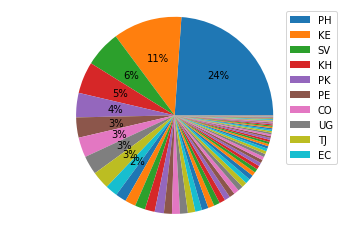

In [ ]:
sizes = pd.DataFrame(np.array(loans_country[["id"]]),index=a)

fig1, ax = plt.subplots()

def autopct_more_than_1(pct):
    return ('%1.f%%' % pct) if pct > 2 else ''

p,t,a = ax.pie(sizes.values, autopct=autopct_more_than_1)
ax.axis('equal') 

# normalize dataframe (not actually needed here, but for general case)
normsizes = sizes/sizes.sum()*100
# create handles and labels for legend, take only those where value is > 1
h,l = zip(*[(h,lab) for h,lab,i in zip(p,sizes.index.values,normsizes.values) if i > 2])

ax.legend(h, l,loc="best", bbox_to_anchor=(1,1))

plt.savefig("counry_pie.png")


In [ ]:
sizes = pd.DataFrame(loans_country[["id"]],index=loans_country[["country_code"]])

In [ ]:
a = np.array(loans_country[["country_code"]])

In [ ]:
a = a.reshape(a.shape[0])

In [ ]:
a

array(['PH', 'KE', 'SV', 'KH', 'PK', 'PE', 'CO', 'UG', 'TJ', 'EC', 'PY',
       'NI', 'IN', 'VN', 'NG', 'BO', 'LB', 'AM', 'PS', 'WS', 'GT', 'RW',
       'ML', 'HN', 'ID', 'US', 'KG', 'TG', 'MX', 'SL', 'TZ', 'GH', 'JO',
       'ZW', 'MG', 'LR', 'HT', 'MZ', 'SN', 'CD', 'TL', 'BF', 'GE', 'YE',
       'CM', 'AZ', 'AL', 'MM', 'TR', 'EG', 'CR', 'LA', 'XK', 'MW', 'IQ',
       'MN', 'UA', 'BI', 'ZM', 'NP', 'SB', 'BJ', 'DO', 'LS', 'ZA', 'MD',
       'BR', 'SR', 'PA', 'IL', 'TH', 'SS', 'CN', 'CG', 'BZ', 'SO', 'PR',
       'VC', 'CL', 'VU', 'BT', 'VI', 'AF', 'CI', 'MR', 'GU'], dtype=object)

# Feature Engineering

In [ ]:
loans_new = loans.drop(['id','loan_amount', 'activity', 'use', 'posted_time', \
                    'disbursed_time', 'funded_time', 'tags', 'date'], axis = 1)
loans_new = loans_new.dropna()

# Select random samples
r.seed(0)
samplesize = 30000
loans_new = loans_new.sample(samplesize)
loans_new = loans_new.join(loans_mpi, on = 'country').dropna()
N = len(loans_new)
loans_train = loans_new.iloc[0:int(0.7*N),:]
loans_val = loans_new.iloc[int(0.7*N):int(0.85*N),:]
loans_test = loans_new.iloc[int(0.85*N):,:]

In [ ]:
train_country = np.unique(np.array(loans_train[['country_code']]))
val_country = np.unique(np.array(loans_val[['country_code']]))
test_country = np.unique(np.array(loans_test[['country_code']]))
a1 = np.intersect1d(train_country, val_country)
a2 = np.intersect1d(a1, test_country)
loans_train = loans_train[loans_train.country_code.isin(a2)]
loans_val = loans_val[loans_val.country_code.isin(a2)]
loans_test = loans_test[loans_test.country_code.isin(a2)]

The fact that some countries don't have MPI, so we have to drop them in clustering. Including one feature results in loss of granularity of another one.

# Basic ALS Algorithm

In [ ]:
def ALS(X, Y, P, C, alpha, lamda, m, n, f):
    A = np.transpose(X).dot(X)
    for i in range(n):
        #pi = X.dot(np.transpose(Y[i,:]))
        pi = P[:,i]
        ci = np.diag(C[:,i])
        M1 = A + np.transpose(X).dot(ci-np.identity(m)).dot(X)+lamda*np.identity(f)
        M2 = np.linalg.inv(M1)
        Y[i,:] = M2.dot(np.transpose(X)).dot(ci).dot(pi)
        
    B = np.transpose(Y).dot(Y)
    for u in range(m):
        #pu = np.transpose(X[u,:].dot(np.transpose(Y)))
        pu = np.transpose(P[u,:])
        cu = np.diag(np.transpose(C[u,:]))
        M1 = B + np.transpose(Y).dot(cu-np.identity(n)).dot(Y)+lamda*np.identity(f)
        M2 = np.linalg.inv(M1)
        X[u,:] = M2.dot(np.transpose(Y)).dot(cu).dot(pu)
    
    Lost = np.sum(C*((P-X.dot(np.transpose(Y)))**2)) + lamda*np.sum(np.diag(X.dot(np.transpose(X)))) + lamda*np.sum(np.diag(Y.dot(np.transpose(Y))))
    return X, Y, Lost

In [ ]:
# function to calculate the preference given a dataset and a label
def pre_ALS(loans_train, item_name, lamda=0.1, max_iter=50):

  users = pd.unique(loans_train['partner_id'])
  users = np.array(users, dtype= int)
  users = np.sort(users)
  
  items = pd.unique(loans_train[item_name])
  items = np.array(items)
  items = np.sort(items)
  
  indexed_items = pd.DataFrame({'index_i':range(0,len(items)), item_name:items})
  indexed_users = pd.DataFrame({'index_u':range(0,len(users)), 'partner_id':users})
  
  df = loans_train.join(indexed_items.set_index(item_name),on=item_name)
  df = df.join(indexed_users.set_index('partner_id'),on='partner_id')
  df = df.groupby(['index_i', 'index_u']).size().reset_index(name='count').drop_duplicates(subset='index_u')
  
  R = np.zeros((len(users),len(items)))
  item_index = np.array(df[['index_i']])
  user_index = np.array(df[['index_u']])
  count_ui = np.array(df[['count']])
  R[user_index,item_index] = count_ui
  alpha = np.sum(R>0)/np.sum(R==0)
  
  m = len(users)
  n = len(items)
  
  f=5
  #lamda = 0.1
  X = np.ones((m,f))*0.5
  Y = np.zeros((n,f))
  P = np.zeros((m,n))
  P[user_index,item_index] = 1.0
  C = 1+alpha*R
  
  max_iter = 50
  loss = [0]*max_iter
  for k in range(max_iter):
    X, Y, l = ALS(X, Y, P, C, alpha, lamda, m, n, f)
    loss[k] = l

  return indexed_users, indexed_items, X, Y, loss, P

# ALS with K

In [ ]:
def ALS_FR1(X, Y, P, C, alpha, lamda, m, n, f, K):
    A = np.transpose(X).dot(X)
    for i in range(n):
        #pi = X.dot(np.transpose(Y[i,:]))
        pi = P[:,i]
        ci = np.diag(C[:,i])
        ki = np.diag(K[:,i])
        M1 = A + np.transpose(X).dot(ci.dot(ki**2)-np.identity(m)).dot(X)+lamda*np.identity(f)
        M2 = np.linalg.inv(M1)
        Y[i,:] = M2.dot(np.transpose(X)).dot(ci).dot(ki).dot(pi)
        
    B = np.transpose(Y).dot(Y)
    for u in range(m):
        #pu = np.transpose(X[u,:].dot(np.transpose(Y)))
        pu = np.transpose(P[u,:])
        cu = np.diag(np.transpose(C[u,:]))
        ku = np.diag(np.transpose(K[u,:]))
        M1 = B + np.transpose(Y).dot(cu.dot(ku**2)-np.identity(n)).dot(Y)+lamda*np.identity(f)
        M2 = np.linalg.inv(M1)
        X[u,:] = M2.dot(np.transpose(Y)).dot(cu).dot(ku).dot(pu)
    
    Lost = np.sum(C*((P-K*X.dot(np.transpose(Y)))**2)) + lamda*np.sum(np.diag(X.dot(np.transpose(X)))) + lamda*np.sum(np.diag(Y.dot(np.transpose(Y))))
    return X, Y, Lost

In [ ]:
# function to calculate the preference given a dataset and a label
def pre_ALSFR1(loans_train, X0, Y0, item_name, lamda=0.1, max_iter=50):

  users = pd.unique(loans_train['partner_id'])
  users = np.array(users, dtype= int)
  users = np.sort(users)
  
  items = pd.unique(loans_train[item_name])
  items = np.array(items)
  items = np.sort(items)
  
  indexed_items = pd.DataFrame({'index_i':range(0,len(items)), item_name:items})
  indexed_users = pd.DataFrame({'index_u':range(0,len(users)), 'partner_id':users})
  
  df = loans_train.join(indexed_items.set_index(item_name),on=item_name)
  df = df.join(indexed_users.set_index('partner_id'),on='partner_id')
  df = df.groupby(['index_i', 'index_u']).size().reset_index(name='count').drop_duplicates(subset='index_u')
  
  R = np.zeros((len(users),len(items)))
  item_index = np.array(df[['index_i']])
  user_index = np.array(df[['index_u']])
  count_ui = np.array(df[['count']])
  R[user_index,item_index] = count_ui
  alpha = np.sum(R>0)/np.sum(R==0)
  
  m = len(users)
  n = len(items)
  
  f=5
  #lamda = 0.1
  X = np.ones((m,f))*0.5
  Y = np.zeros((n,f))
  P = np.zeros((m,n))
  P[user_index,item_index] = 1.0
  C = 1+alpha*R
  p_final = X0.dot(Y0.T)
  K = 1.3*np.exp(p_final)

  max_iter = 50
  loss = [0]*max_iter
  for k in range(max_iter):
    X, Y, l = ALS_FR1(X, Y, P, C, alpha, lamda, m, n, f, K)
    loss[k] = l

  return indexed_users, indexed_items, X, Y, loss, P

# ALS with Neighborhood Fairness by Gradient Descent

In [ ]:
def ALS_FR2(X, Y, P, C, alpha, lamda1, lamda2, m, n, f, INFO, lr):
    
    y_sum = np.sum(Y*INFO,axis=0).reshape(1,f)
    x_sum = np.sum(X, axis=0).reshape(1,f)

    X_new = X
    Y_new = Y

    A = np.transpose(X).dot(X)
    for i in range(n):
        #pi = X.dot(np.transpose(Y[i,:]))
        pi = P[:,i]
        ci = np.diag(C[:,i])
        M1 = A + np.transpose(X).dot(ci-np.identity(m)).dot(X)+lamda1*np.identity(f)        
        if INFO[i,0]==1:          
          M2 = -(np.transpose(X).dot(ci).dot(pi)).reshape(f,1)+lamda2*(x_sum.T.dot(x_sum).dot(y_sum.T))
        else:
          M2 = -(np.transpose(X).dot(ci).dot(pi)).reshape(f,1)-lamda2*(x_sum.T.dot(x_sum).dot(y_sum.T))
        
        Y_new[i,:] = -lr*(M1.dot(Y[i,:].T).reshape(f,1)+M2).T+Y[i,:]
        
    B = np.transpose(Y).dot(Y)
    for u in range(m):
        #pu = np.transpose(X[u,:].dot(np.transpose(Y)))
        pu = np.transpose(P[u,:])
        cu = np.diag(np.transpose(C[u,:]))
        M1 = B + np.transpose(Y).dot(cu-np.identity(n)).dot(Y)+lamda1*np.identity(f)
        M2 = (np.transpose(Y).dot(cu).dot(pu)).reshape(f,1)-lamda2*(y_sum.T.dot(y_sum).dot(x_sum.T))        
        X_new[u,:] = -lr*(M1.dot(X[u,:].T).reshape(f,1)+M2).T+X[u,:]
    
    X = X_new
    Y = Y_new
    
    Lost = np.sum(C*((P-X.dot(np.transpose(Y)))**2)) + lamda1*np.sum(np.diag(X.dot(np.transpose(X)))) + lamda2*np.sum(np.diag(Y.dot(np.transpose(Y))))+lamda2*(np.sum(X.dot((Y*INFO).T)))**2

    return X, Y, Lost

In [ ]:
def pre_ALSFR2(loans_train, X0, Y0, item_name, lamda1=0.1, lamda2=3.0, max_iter=1000, lr=1.0e-7):

  users = pd.unique(loans_train['partner_id'])
  users = np.array(users, dtype= int)
  users = np.sort(users)
  
  items = pd.unique(loans_train[item_name])
  items = np.array(items)
  items = np.sort(items)
  
  indexed_items = pd.DataFrame({'index_i':range(0,len(items)), item_name:items})
  indexed_users = pd.DataFrame({'index_u':range(0,len(users)), 'partner_id':users})
  
  df = loans_train.join(indexed_items.set_index(item_name),on=item_name)
  df = df.join(indexed_users.set_index('partner_id'),on='partner_id')
  df = df.groupby(['index_i', 'index_u']).size().reset_index(name='count').drop_duplicates(subset='index_u')
  
  R = np.zeros((len(users),len(items)))
  item_index = np.array(df[['index_i']])
  user_index = np.array(df[['index_u']])
  count_ui = np.array(df[['count']])
  R[user_index,item_index] = count_ui
  alpha = np.sum(R>0)/np.sum(R==0)
  
  f=5
  m = len(users)
  n = len(items)
  X = np.copy(X0)
  Y = np.copy(Y0)
  P = np.zeros((m,n))
  P[user_index,item_index] = 1.0
  C = 1+alpha*R
  
  pre = np.sum(X.dot(Y.T), axis = 0)
  item_up_index = np.where(pre>0.3*np.max(pre))
  INFO = np.ones((n,f))
  INFO[item_up_index,:] = -1

  #max_iter = 1000
  loss = [0]*max_iter
  for k in range(max_iter):
    X, Y, l = ALS_FR2(X, Y, P, C, alpha, lamda1, lamda2, m, n, f, INFO, lr)
    loss[k] = l
  
  return indexed_users, indexed_items, X, Y, loss, P

# ALS with K and Neighborhood Fairness by Gradient Descent

In [ ]:
def ALS_FR3(X, Y, P, C, K, alpha, lamda1, lamda2, m, n, f, INFO, lr):
    
    y_sum = np.sum(Y*INFO,axis=0).reshape(1,f)
    x_sum = np.sum(X, axis=0).reshape(1,f)

    X_new = X
    Y_new = Y

    A = np.transpose(X).dot(X)
    for i in range(n):
        #pi = X.dot(np.transpose(Y[i,:]))
        pi = P[:,i]
        ci = np.diag(C[:,i])
        ki = np.diag(K[:,i])
        M1 = A + np.transpose(X).dot(ci.dot(ki**2)-np.identity(m)).dot(X)+lamda1*np.identity(f)        
        if INFO[i,0]==1:          
          M2 = -(np.transpose(X).dot(ci).dot(ki).dot(pi)).reshape(f,1)+lamda2*(x_sum.T.dot(x_sum).dot(y_sum.T))
        else:
          M2 = -(np.transpose(X).dot(ci).dot(ki).dot(pi)).reshape(f,1)-lamda2*(x_sum.T.dot(x_sum).dot(y_sum.T))
        
        Y_new[i,:] = -lr*(M1.dot(Y[i,:].T).reshape(f,1)+M2).T+Y[i,:]
        
    B = np.transpose(Y).dot(Y)
    for u in range(m):
        #pu = np.transpose(X[u,:].dot(np.transpose(Y)))
        pu = np.transpose(P[u,:])
        cu = np.diag(np.transpose(C[u,:]))
        ku = np.diag(np.transpose(K[u,:]))
        M1 = B + np.transpose(Y).dot(cu.dot(ku**2)-np.identity(n)).dot(Y)+lamda*np.identity(f)
        M2 = (np.transpose(Y).dot(cu).dot(ku).dot(pu)).reshape(f,1)-lamda2*(y_sum.T.dot(y_sum).dot(x_sum.T))        
        X_new[u,:] = -lr*(M1.dot(X[u,:].T).reshape(f,1)+M2).T+X[u,:]
    
    X = X_new
    Y = Y_new
    
    Lost = np.sum(C*((P-K*X.dot(np.transpose(Y)))**2)) + lamda1*np.sum(np.diag(X.dot(np.transpose(X)))) + lamda2*np.sum(np.diag(Y.dot(np.transpose(Y))))+lamda2*(np.sum(X.dot((Y*INFO).T)))**2

    return X, Y, Lost

# Use Country as Items to group loans

In [ ]:
# Use country as items and without fairness
users_df, items_df, X, Y, loss, P = pre_ALS(loans_train, 'country_code')
users_df, items_df, X1, Y1, loss1, P1 = pre_ALSFR1(loans_train, X, Y, 'country_code')
users_df, items_df, X2, Y2, loss2, P2 = pre_ALSFR2(loans_train, X, Y, 'country_code')

In [ ]:
def plot_fr(items, X, Y, X1, Y1, X2, Y2, fname, fsize=(30,10), ylimit=(-10,30), w=0.8, legend=['Without Fairness', 'Pairwise Fairness', 'Neighborhood Fairness']):
  pre = np.sum(X.dot(Y.T), axis = 0)
  pre1 = np.sum(X1.dot(Y1.T), axis=0)
  pre2 = np.sum(X2.dot(Y2.T), axis=0)
  pre_sorted,pre1_sorted, pre2_sorted, items_sorted = zip(*sorted(zip(pre, pre1, pre2, items),reverse=True))
  
  x = 2*np.arange(len(items_sorted))
  plt.figure(figsize=fsize)
  ax1 = plt.subplot(1,1,1)
  
  w = 0.5
  plt.xticks(x, items_sorted, rotation='vertical', fontsize=20)
  legend1 =ax1.bar(x, pre_sorted, width=w, color='red')
  plt.ylim(ylimit[0],ylimit[1])
  
  plt.ylabel('Preference', fontsize=25)
  plt.yticks(fontsize=25)
  
  ax2 = ax1.twinx()
  legend2 =ax2.bar(x + w, pre1_sorted, width=w, color='blue')
  plt.ylim(ylimit[0],ylimit[1])
  plt.yticks(fontsize=25)

  ax3 = ax1.twinx()
  legend3 =ax3.bar(x + 2*w, pre2_sorted, width=w, color='orange')
  plt.ylim(ylimit[0],ylimit[1])
  plt.yticks(fontsize=25)

  plt.legend([legend1, legend2, legend3],legend,fontsize=30)
  plt.savefig(fname, bbox_inches = "tight")

In [ ]:
plot_fr(items_df['country_code'], X, Y, X1, Y1, X2, Y2, 'coutry_code.png', ylimit=(-5,25))

In [ ]:
A1 = np.sum(X.dot(Y.T), axis=0)
A2 = np.sum(X1.dot(Y1.T), axis=0)
A3 = np.sum(X2.dot(Y2.T), axis=0)
np.var(A1), np.var(A2), np.var(A3)

(27.74392115549596, 9.32377275435769, 16.481490778411317)

In [ ]:
np.max(A1)-np.min(A1), np.max(A2)-np.min(A2), np.max(A3)-np.min(A3)

(20.839366016680128, 10.761646140778378, 17.18294092248555)

# Use Sector as Items to group loans

In [ ]:
users_df, items_df, X, Y, loss, P = pre_ALS(loans_train, 'sector')
users_df, items_df, X1, Y1, loss1, P1 = pre_ALSFR1(loans_train, X, Y, 'sector')
users_df, items_df, X2, Y2, loss2, P2 = pre_ALSFR2(loans_train, X, Y, 'sector')

In [ ]:
plot_fr(items_df['sector'], X, Y, X1, Y1, X2, Y2, 'sector.png', ylimit=(-5,110))

In [ ]:
A1 = np.sum(X.dot(Y.T), axis=0)
A2 = np.sum(X1.dot(Y1.T), axis=0)
A3 = np.sum(X2.dot(Y2.T), axis=0)
np.var(A1), np.var(A2), np.var(A3)


(575.8839498674454, 50.17917026824296, 496.9113084481569)

In [ ]:
np.max(A1)-np.min(A1), np.max(A2)-np.min(A2), np.max(A3)-np.min(A3)

(99.29024221889036, 30.369858382577117, 92.20343098275345)

# Clustering different features

In [ ]:
# encode the features into onehot vectors
def encode(loans_new, nbins):
  # encode the gender
  gender = np.zeros((loans_new.shape[0],1))
  gen_list = loans_new[['borrower_genders']].values.tolist()
  
  for i in range(len(gen_list)):
    gen_split = gen_list[i][0].split(', ')
    if ('male' in gen_split) and ('female' in gen_split):
      gender[i] = 0.5
    elif 'male' in gen_split:
      gender[i] = 0
    else:
      gender[i] = 1
  enc = OneHotEncoder(handle_unknown='ignore')
  enc.fit(gender)
  enc.categories_
  enc1 = enc.transform(gender).toarray()

  # encode the country code
  enc2 = OneHotEncoder(handle_unknown='ignore')
  enc2.fit(loans_new[['country_code']])
  enc2.categories_
  enc2 = enc2.transform(loans_new[['country_code']]).toarray()

  # encode the sector
  enc3 = OneHotEncoder(handle_unknown='ignore')
  enc3.fit(loans_new[['sector']])
  enc3.categories_
  enc3 = enc3.transform(loans_new[['sector']]).toarray()

  # encode the MPI
  est = KBinsDiscretizer(n_bins=nbins, encode='ordinal', strategy='uniform')
  est = est.fit(np.array(loans_new[['MPI']]))
  est1 = est.transform(np.array(loans_new[['MPI']]))
  
  enc4 = OneHotEncoder(handle_unknown='ignore')
  enc4.fit(est1)
  enc4.categories_
  enc4 = enc4.transform(est1).toarray()

  enc_final = np.concatenate((enc1, enc2, enc3, enc4), axis = 1)
  return enc_final

In [ ]:
enc_train = encode(loans_train, 10)
enc_val = encode(loans_val, 10)
enc_test = encode(loans_test, 10)


In [ ]:
loans_new = loans.drop(['id','loan_amount', 'activity', 'use', 'posted_time', \
                    'disbursed_time', 'funded_time', 'tags', 'date'], axis = 1)
loans_new = loans_new.dropna()
loans_new = loans_new.join(loans_mpi, on = 'country').dropna()

In [ ]:
enc_total = encode(loans_new, 10)

calculate the hamming distance for the training data and do the agglomerative clustering.

In [ ]:
def ham(x, y):
  dist = np.sum(x!=y)
  return dist
train_dist = pairwise_distances(enc_train, metric=ham)

In [ ]:
#Find the clusteroid
def find_clusteroid(enc_final, label, nc):
  clusteroid = np.zeros((nc, enc_final.shape[1]))
  for i in range(nc):
    temp = enc_final[np.where(label==i)[0],:]
    clusteroid[i,:] = np.mean(temp, axis=0)
  return clusteroid

#Find the clusterweight based on the clusteroid for each loan
def find_clusterweight(enc_final, clusteroid, nc):
  clusterdist = np.zeros((enc_final.shape[0], nc))
  for i in range(enc_final.shape[0]):
    for j in range(nc):
      clusterdist[i,j]=np.sqrt(np.sum((enc_final[i,:]-clusteroid[j,:])**2))
  clusterw = np.zeros((enc_final.shape[0], nc))
  for i in range(enc_final.shape[0]):
    temp = clusterdist[i,:]
    top5_index = np.argsort(temp)[0:5]
    if np.sum(temp[top5_index]==0)==0:
      top5_w = 1/temp[top5_index]
      clusterw[i,top5_index] = top5_w
      clusterw[i,:] = clusterw[i,:]/np.sum(clusterw[i,:])
    else:
      clusterw[top5_index[0]]=1.0
  return clusterw

#Make recommendations based on clusteroid and estimated preferences
def person_recom(X, Y, clusteroid, topN, enc_test, nc):  
  clusterw = find_clusterweight(enc_test, clusteroid, nc)
  user_recom = np.zeros((X.shape[0],topN))
  for i in range(X.shape[0]):
    pi = X[i,:].dot(Y.T)
    pw = clusterw.dot(pi)
    pw_index = np.argsort(-pw)[0:topN]
    user_recom[i,:]=pw_index
  return user_recom

In [ ]:
cluster = AgglomerativeClustering(n_clusters=33, affinity='l1', linkage='average')
train_label = cluster.fit_predict(enc_train)

In [ ]:
train_label.reshape((train_label.shape[0],1))
df = loans_train
df['cluster']=train_label

In [ ]:
loans_train.head(3)

In [ ]:
users_df, items_df, X, Y, loss, P = pre_ALS(loans_train, 'cluster')
users_df, items_df, X1, Y1, loss1, P1 = pre_ALSFR1(loans_train, X, Y, 'cluster')
users_df, items_df, X2, Y2, loss2, P2 = pre_ALSFR2(loans_train, X, Y, 'cluster')

In [ ]:
plot_fr(items_df['cluster'], X, Y, X1, Y1, X2, Y2, 'cluster.png', ylimit=(-5,35))

In [ ]:
clusteroid = find_clusteroid(enc_train, train_label, 33)

In [ ]:
topN = 100
recom1 = person_recom(X, Y, clusteroid, topN, enc_val, 33)
recom2 = person_recom(X2, Y2, clusteroid, topN, enc_val, 33)

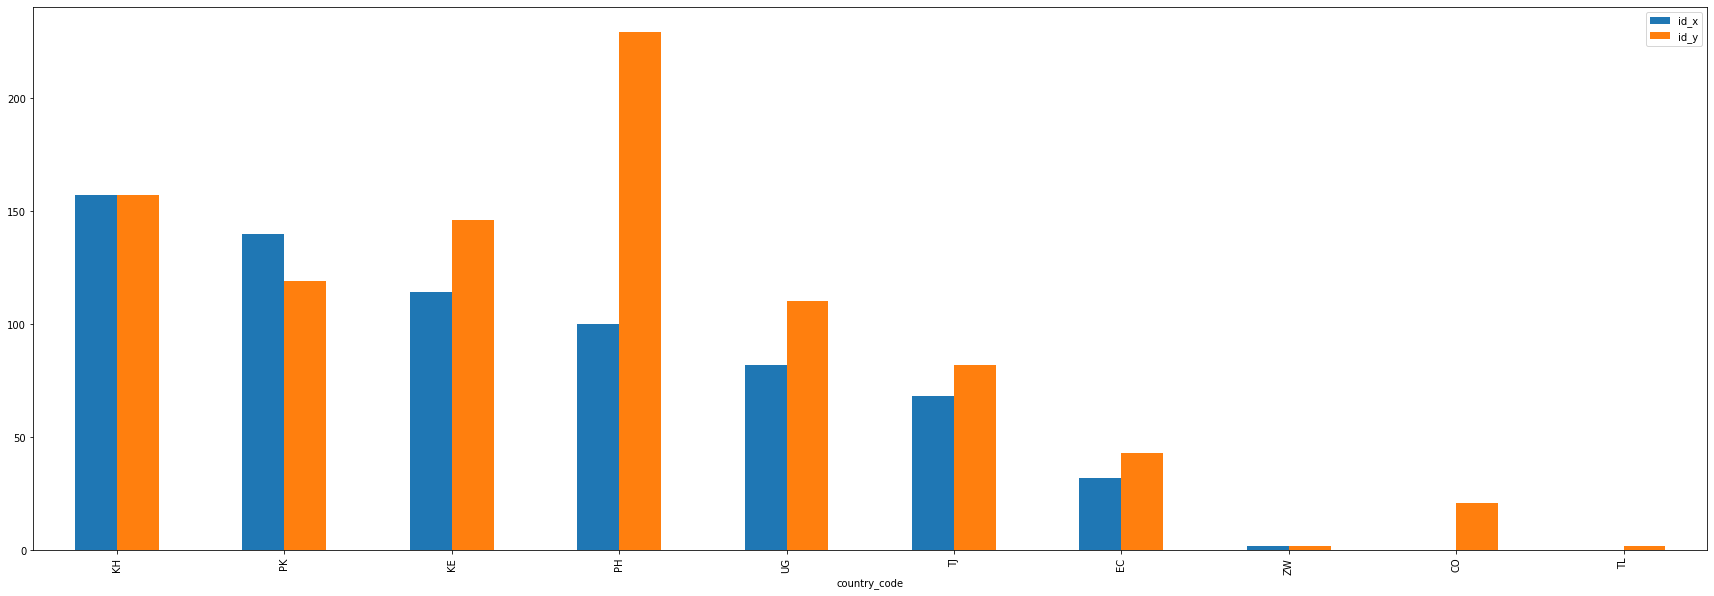

In [ ]:
loans_recom1 = loans_val.iloc[np.unique(recom1),:]
loans_recom1 = loans_recom1.groupby('country_code')['id'].count()
loans_recom1 = pd.DataFrame(loans_recom1)
loans_recom1 = loans_recom1.reset_index('country_code')

loans_recom2 = loans_val.iloc[np.unique(recom2),:]
loans_recom2 = loans_recom2.groupby('country_code')['id'].count()
loans_recom2 = pd.DataFrame(loans_recom2)
loans_recom2 = loans_recom2.reset_index('country_code')

loans_recom = pd.merge(loans_recom1,loans_recom2,on='country_code',how='outer').fillna(value=0)
loans_recom = loans_recom.sort_values('id_x', ascending=False)

loans_recom.plot.bar(x="country_code", y=["id_x", "id_y"],figsize=(30,10))

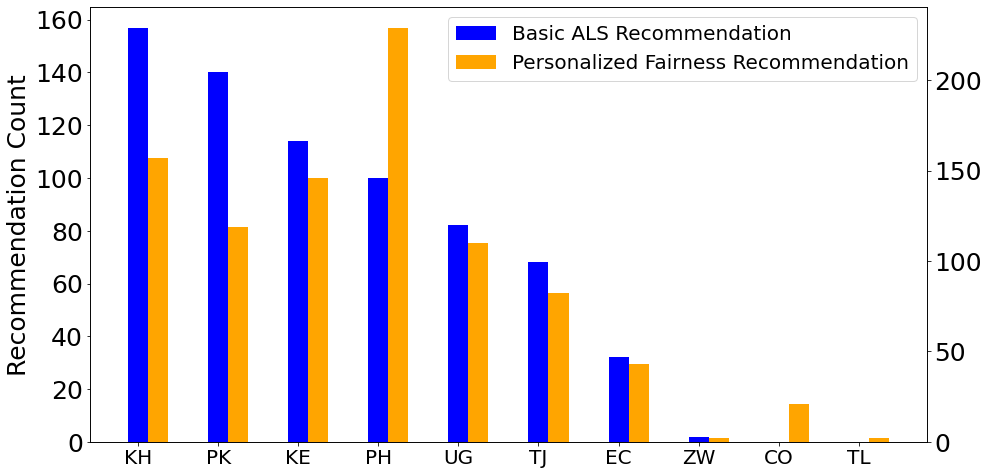

In [ ]:
x = 2*np.arange(len(loans_recom))
plt.figure(figsize=(15,8))
ax1 = plt.subplot(1,1,1)

x_item = np.array(list(loans_recom['country_code']))
y1 = np.array(list(loans_recom['id_x']))
y2 = np.array(list(loans_recom['id_y']))

w = 0.5
plt.xticks(x, x_item, fontsize=20)
legend1 =ax1.bar(x, y1, width=w, color='blue')
#plt.ylim(ylimit[0],ylimit[1])

plt.ylabel('Recommendation Count', fontsize=25)
plt.yticks(fontsize=25)

ax2 = ax1.twinx()
legend2 =ax2.bar(x + w, y2, width=w, color='orange')
#plt.ylim(ylimit[0],ylimit[1])
plt.yticks(fontsize=25)

plt.legend([legend1, legend2],['Basic ALS Recommendation', 'Personalized Fairness Recommendation'],fontsize=20)
plt.savefig('personafr_country.png', bbox_inches = "tight")

In [ ]:
np.sum(y1)/len(loans_val), np.sum(y2)/len(loans_val)

(0.18677774791722654, 0.24482665950013438)

In [ ]:
loans_recom1 = loans_val.iloc[np.unique(recom1),:]
loans_recom1 = loans_recom1.groupby('sector')['id'].count()
loans_recom1 = pd.DataFrame(loans_recom1)
loans_recom1 = loans_recom1.reset_index('sector')

loans_recom2 = loans_val.iloc[np.unique(recom2),:]
loans_recom2 = loans_recom2.groupby('sector')['id'].count()
loans_recom2 = pd.DataFrame(loans_recom2)
loans_recom2 = loans_recom2.reset_index('sector')

loans_recom = pd.merge(loans_recom1,loans_recom2,on='sector',how='outer').fillna(value=0)
loans_recom = loans_recom.sort_values('id_x', ascending=False)

loans_recom.plot.bar(x="sector", y=["id_x", "id_y"],figsize=(30,10))

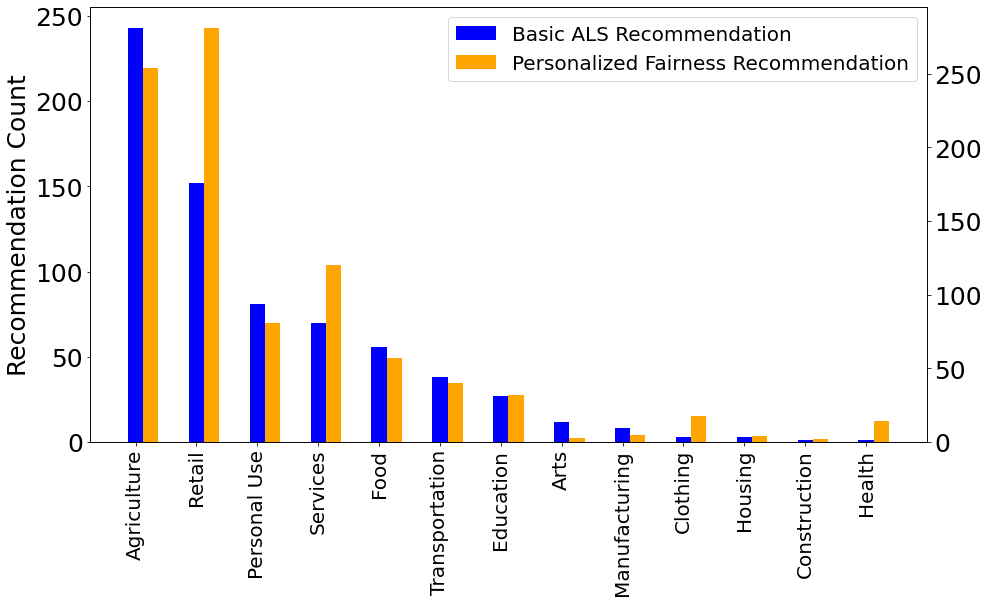

In [ ]:
x = 2*np.arange(len(loans_recom))
plt.figure(figsize=(15,8))
ax1 = plt.subplot(1,1,1)

x_item = np.array(list(loans_recom['sector']))
y1 = np.array(list(loans_recom['id_x']))
y2 = np.array(list(loans_recom['id_y']))

w = 0.5
plt.xticks(x, x_item, rotation=90, fontsize=20)
legend1 =ax1.bar(x, y1, width=w, color='blue')
#plt.ylim(ylimit[0],ylimit[1])

plt.ylabel('Recommendation Count', fontsize=25)
plt.yticks(fontsize=25)

ax2 = ax1.twinx()
legend2 =ax2.bar(x + w, y2, width=w, color='orange')
#plt.ylim(ylimit[0],ylimit[1])
plt.yticks(fontsize=25)

plt.legend([legend1, legend2],['Basic ALS Recommendation', 'Personalized Fairness Recommendation'],fontsize=20)
plt.savefig('personafr_sector.png', bbox_inches = "tight")

In [ ]:
r#Run on validation dataset
nc = np.arange(10,40)
topN = 100
accuracy2 = np.zeros(nc.shape)
for i in range(len(nc)):
  cluster = AgglomerativeClustering(n_clusters=nc[i], affinity = 'l1', linkage='average')
  train_label = cluster.fit_predict(enc_train)

  train_label.reshape((train_label.shape[0],1))
  df = loans_train
  df['cluster']=train_label

  clusteroid = find_clusteroid(enc_train, train_label, nc[i])

  users_df, items_df, X, Y, loss, P = pre_ALS(df, item_name = 'cluster', lamda=0.1, max_iter=50)
  users_df, items_df, X_fr, Y_fr, loss_fr, P_fr = pre_ALSFR2(df, X, Y, item_name='cluster',\
                                                       lamda1=0.1, lamda2=3.0, max_iter=1000, lr=1.0e-7)

  recom1 = person_recom(X, Y, clusteroid, topN, enc_test, nc[i])
  recom2 = person_recom(X_fr, Y_fr, clusteroid, topN, enc_test, nc[i])

  recom_intersect = np.zeros(len(users_df))
  for j in range(len(users_df)):
    recom_intersect[j] = np.intersect1d(np.unique(recom1[j,:]), np.unique(recom2[j,:])).shape[0]
  accuracy2[i] = np.mean(recom_intersect)

In [ ]:
#Try different lambda
nc = 33
topN = 100
lamda2_values = np.arange(0.0, 5.0, 0.25)
accuracy_lamda = np.zeros(lamda2_values.shape[0])
for i in range(len(lamda2_values)):
  cluster = AgglomerativeClustering(n_clusters=nc, affinity = 'precomputed', linkage='average')
  train_label = cluster.fit_predict(train_dist)

  train_label.reshape((train_label.shape[0],1))
  df = loans_train
  df['cluster']=train_label

  clusteroid = find_clusteroid(enc_train, train_label, nc)

  users_df, items_df, X, Y, loss, P = pre_ALS(df, item_name = 'cluster', lamda=0.1, max_iter=50)
  users_df, items_df, X_fr, Y_fr, loss_fr, P_fr = pre_ALSFR2(df, X, Y, item_name='cluster',\
                                                       lamda1=0.1, lamda2=lamda2_values[i], max_iter=1000, lr=1.0e-7)

  recom1 = person_recom(X, Y, clusteroid, topN, enc_test, nc)
  recom2 = person_recom(X_fr, Y_fr, clusteroid, topN, enc_test, nc)

  recom_intersect = np.zeros(len(users_df))
  for j in range(len(users_df)):
    recom_intersect[j] = np.intersect1d(np.unique(recom1[j,:]), np.unique(recom2[j,:])).shape[0]
  accuracy_lamda[i] = np.mean(recom_intersect)

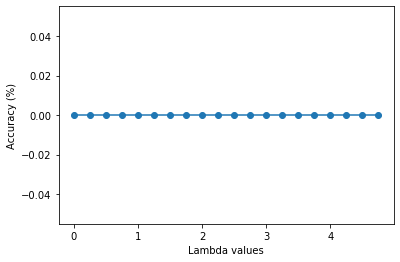

In [ ]:
plt.plot(lamda2_values, accuracy_lamda2, '-o')
plt.xlabel("Lambda values")
plt.ylabel("Accuracy (%)")
plt.savefig("accuracy_lambda2.png")

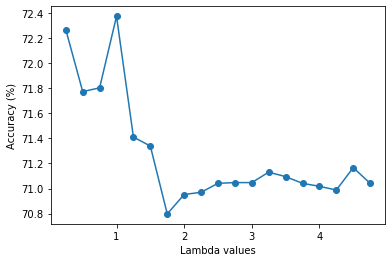

In [ ]:
plt.plot(lamda2_values[1:], accuracy_lamda[1:], '-o')
plt.xlabel("Lambda values")
plt.ylabel("Accuracy (%)")
plt.savefig("accuracy_lambda.png")

In [ ]:
nc = 33
topN = 100
lamda2_values = np.arange(0.0, 5.0, 0.25)
accuracy_lamda2 = np.zeros(lamda2_values.shape[0])

cluster = AgglomerativeClustering(n_clusters=nc, affinity = 'precomputed', linkage='average')
train_label = cluster.fit_predict(train_dist)

train_label.reshape((train_label.shape[0],1))
df = loans_train
df['cluster']=train_label

clusteroid = find_clusteroid(enc_train, train_label, nc)

users_df, items_df, X, Y, loss, P = pre_ALS(df, item_name = 'cluster', lamda=0.1, max_iter=50)

for i in range(len(lamda2_values)):

  users_df, items_df, X_fr, Y_fr, loss_fr, P_fr = pre_ALSFR2(df, X, Y, item_name='cluster',\
                                                       lamda1=0.1, lamda2=lamda2_values[i], max_iter=1000, lr=1.0e-7)
  accuracy_lamda2[i] = np.sum((P-X_fr.dot(Y_fr.T))**2)


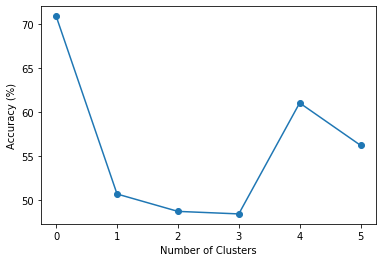

In [ ]:
plt.plot(accuracy2,'-o')
plt.xlabel('Number of Clusters')
plt.ylabel('Accuracy (%)')
plt.savefig("Test_accuracy.png")

In [ ]:
nc = 33

cluster = AgglomerativeClustering(n_clusters=nc, affinity = 'precomputed', linkage='average')
train_label = cluster.fit_predict(train_dist)

train_label.reshape((train_label.shape[0],1))
df = loans_train
df['cluster']=train_label

clusteroid = find_clusteroid(enc_train, train_label, nc)

users_df, items_df, X, Y, loss, P = pre_ALS(df, item_name = 'cluster', lamda=0.1, max_iter=50)

users_df, items_df, X_fr1, Y_fr1, loss_fr, P_fr = pre_ALSFR2(df, X, Y, item_name='cluster',\
                                                       lamda1=0.1, lamda2=3.0, max_iter=1000, lr=1.0e-7)
#users_df, items_df, X_fr2, Y_fr2, loss_fr, P_fr = pre_ALSFR2(df, X, Y, item_name='cluster',\
                                                       #lamda1=0.1, lamda2=100.0, max_iter=5000, lr=1.0e-7)


In [ ]:
def plot_fr(items, X, Y, X1, Y1, fname, fsize=(30,10), ylimit=(-5,30), w=0.8, legend=['Basic ALS', 'Personalized Fairness Model']):
  pre = np.sum(X.dot(Y.T), axis = 0)
  pre1 = np.sum(X1.dot(Y1.T), axis=0)
  #pre2 = np.sum(X2.dot(Y2.T), axis=0)
  pre_sorted,pre1_sorted, items_sorted = zip(*sorted(zip(pre, pre1, items),reverse=True))
  
  x = 2*np.arange(len(items_sorted))
  plt.figure(figsize=fsize)
  ax1 = plt.subplot(1,1,1)
  
  w = 0.5
  plt.xticks(x, items_sorted, fontsize=20)
  legend1 =ax1.bar(x, pre_sorted, width=w, color='red')
  plt.ylim(ylimit[0],ylimit[1])
  
  plt.xlabel('Cluster Label', fontsize=25)
  plt.ylabel('Preference', fontsize=25)
  plt.yticks(fontsize=25)
  
  ax2 = ax1.twinx()
  legend2 =ax2.bar(x + w, pre1_sorted, width=w, color='blue')
  plt.ylim(ylimit[0],ylimit[1])
  plt.yticks(fontsize=25)

  """ax3 = ax1.twinx()
  legend3 =ax3.bar(x + 2*w, pre2_sorted, width=w, color='orange')
  plt.ylim(ylimit[0],ylimit[1])
  plt.yticks(fontsize=25)"""

  plt.legend([legend1, legend2],legend,fontsize=30)
  plt.savefig(fname)

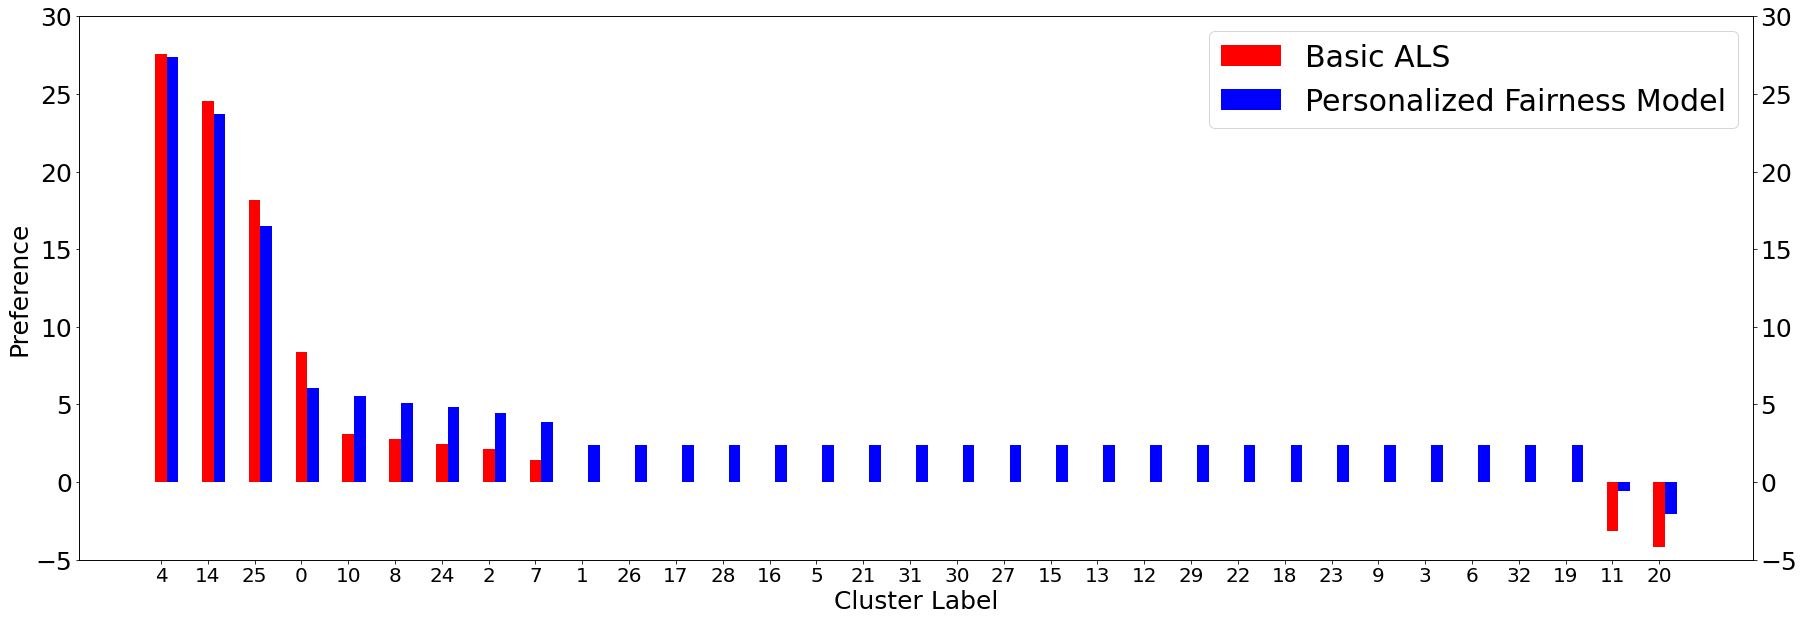

In [ ]:
plot_fr(np.arange(33), X, Y, X_fr1, Y_fr1, 'person_recom.png')

In [ ]:
np.var(X.dot(Y.T)), np.max(X.dot(Y.T))-np.min(X.dot(Y.T)), np.var(X_fr1.dot(Y_fr1.T)), np.max(X_fr1.dot(Y_fr1.T))-np.min(X_fr1.dot(Y_fr1.T))

(0.018528209665141758,
 1.7107761994021717,
 0.017844290974985594,
 1.6796578905121866)

In [ ]:
p1 = np.sum(X.dot(Y.T), axis=0)
p2 = np.sum(X_fr1.dot(Y_fr1.T), axis=0)

In [ ]:
np.var(p1), np.var(p2), np.max(p1)-np.min(p1), np.max(p2)-np.min(p2)

(48.85046298285272, 36.58244263828711, 31.75791181094258, 29.387730828495368)

In [ ]:
recom1 = person_recom(X, Y, clusteroid, 50, enc_test, nc)
recom2 = person_recom(X_fr1, Y_fr1, clusteroid, 50, enc_test, nc)

In [ ]:
len(np.unique(recom1))/enc_test.shape[0]

0.12093523246439129

In [ ]:
len(np.unique(recom2))/enc_test.shape[0]

0.11824778285407149

In [ ]:
np.unique(recom2)

In [ ]:
users_df, items_df, X_fr2, Y_fr2, loss_fr, P_fr = pre_ALSFR2(df, X, Y, item_name='cluster',\
                                                       lamda1=0.1, lamda2=100.0, max_iter=5000, lr=1.0e-7)

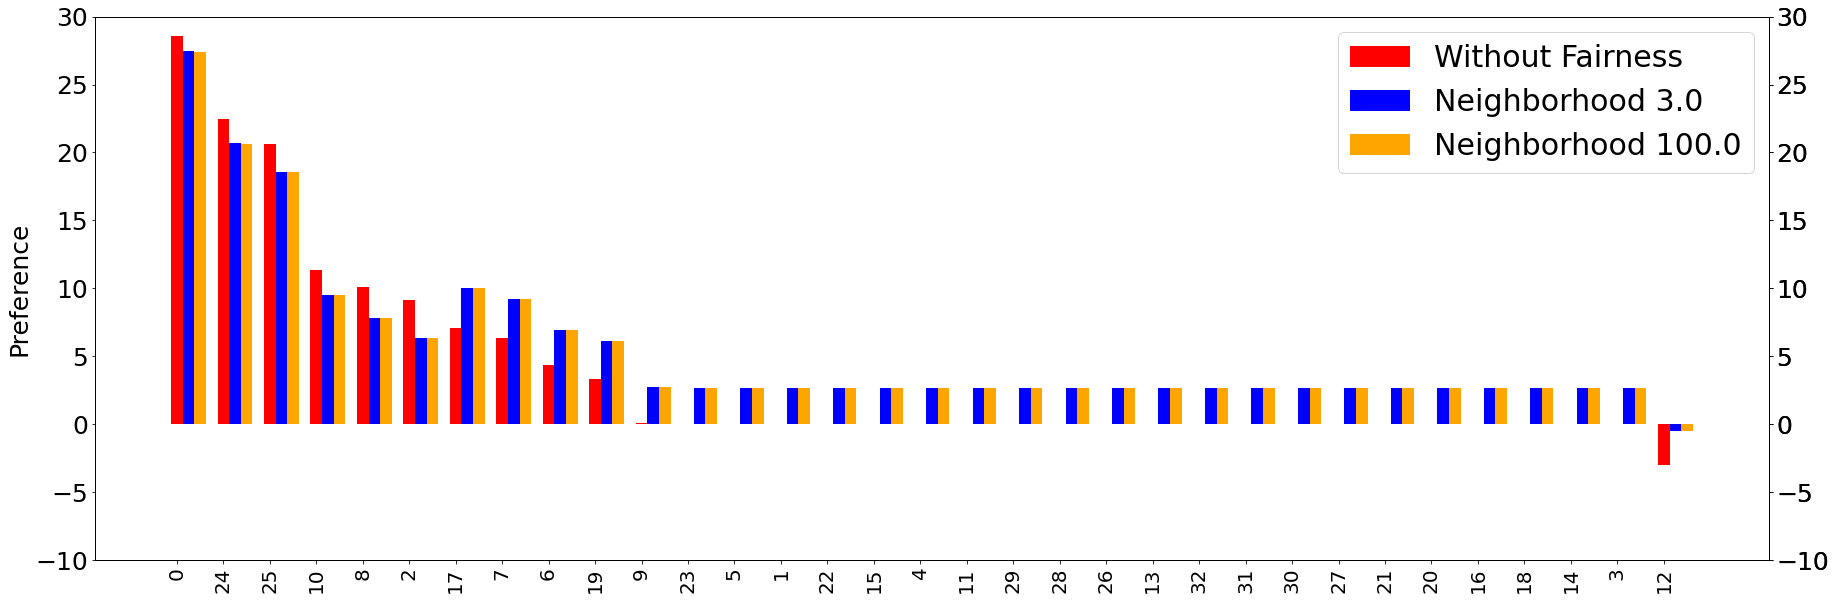

In [ ]:
plot_fr(items_df['cluster'], X, Y, X_fr1, Y_fr1, X_fr2, Y_fr2, 'cluster_different_lambda.png', legend=['Without Fairness', 'Neighborhood 3.0', 'Neighborhood 100.0'])

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(np.arange(10,40), accuracy1, '-o', label='Validation')
ax.plot(np.arange(10,40), accuracy2, '-o', label='Test')

plt.xlabel('Number of Clusters', fontsize=15)
plt.ylabel('Accuracy (%)', fontsize=15)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
legend = ax.legend(loc='lower center', fontsize=15)

plt.savefig("accuracy.png")

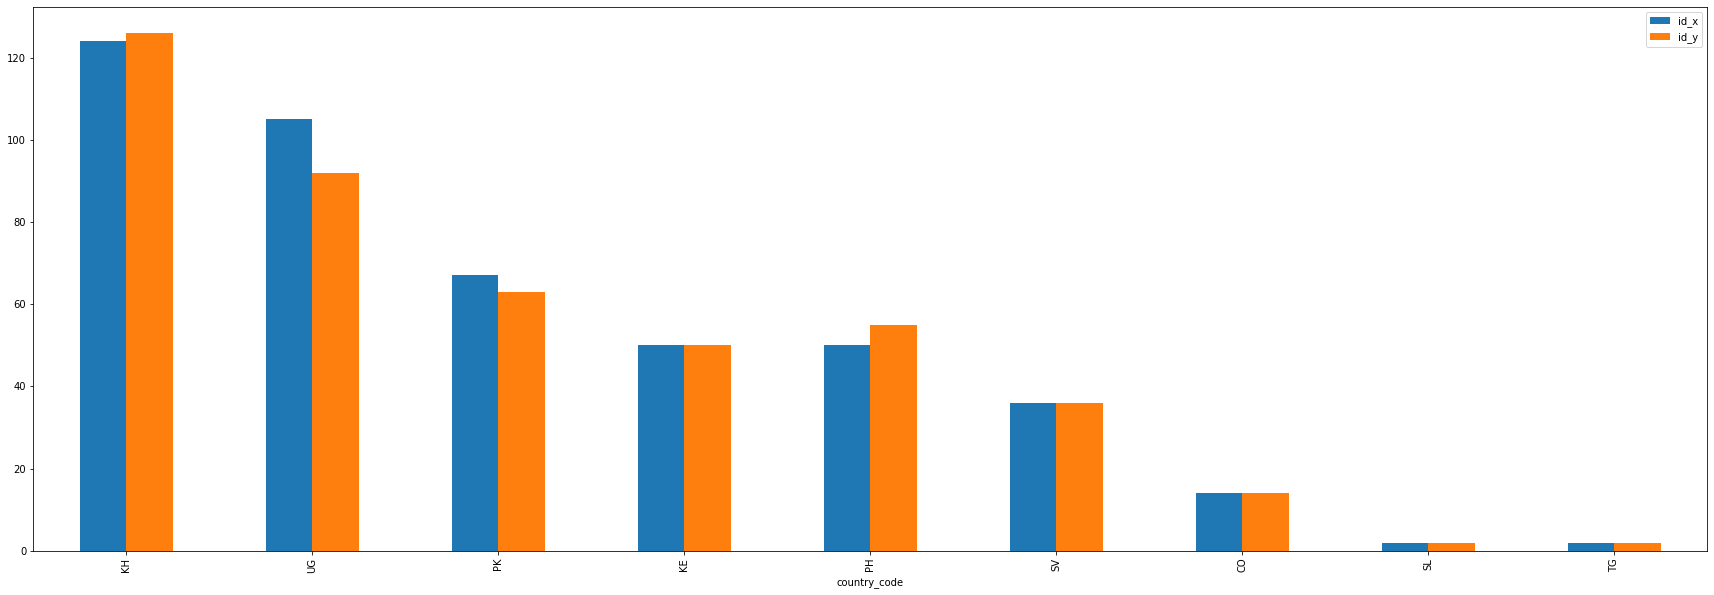

In [ ]:
loans_recom1 = loans_test.iloc[np.unique(recom1),:]
loans_recom1 = loans_recom1.groupby('country_code')['id'].count()
loans_recom1 = pd.DataFrame(loans_recom1)
loans_recom1 = loans_recom1.reset_index('country_code')

loans_recom2 = loans_test.iloc[np.unique(recom2),:]
loans_recom2 = loans_recom2.groupby('country_code')['id'].count()
loans_recom2 = pd.DataFrame(loans_recom2)
loans_recom2 = loans_recom2.reset_index('country_code')

loans_recom = pd.merge(loans_recom1,loans_recom2,on='country_code',how='outer').fillna(value=0)
loans_recom = loans_recom.sort_values('id_x', ascending=False)

loans_recom.plot.bar(x="country_code", y=["id_x", "id_y"],figsize=(30,10))

In [ ]:
len(np.unique(loans_test['country_code']))

41

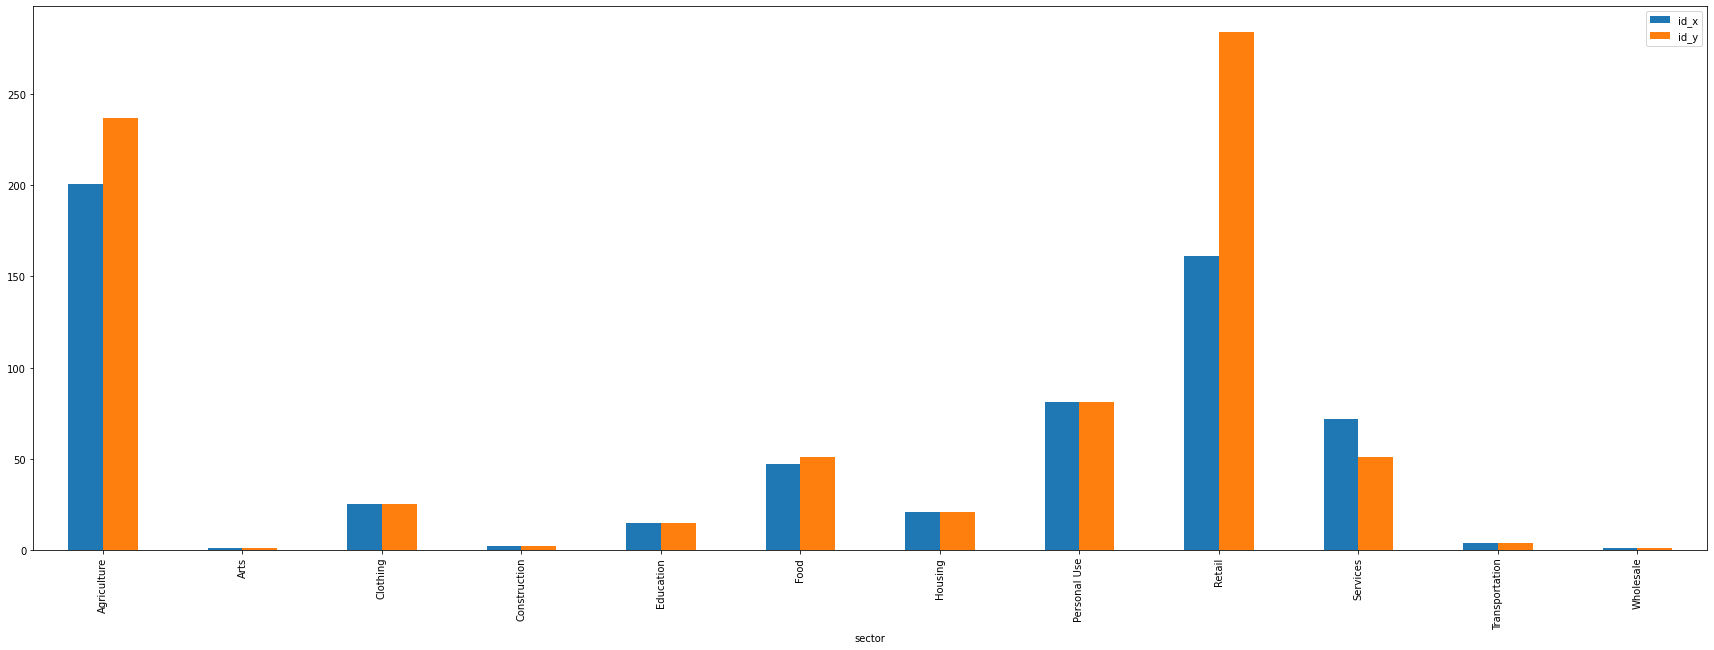

In [ ]:
loans_recom1 = loans_test.iloc[np.unique(recom1),:]
loans_recom1 = loans_recom1.groupby('sector')['id'].count()
loans_recom1 = pd.DataFrame(loans_recom1)
loans_recom1 = loans_recom1.reset_index('sector')

loans_recom2 = loans_test.iloc[np.unique(recom2),:]
loans_recom2 = loans_recom2.groupby('sector')['id'].count()
loans_recom2 = pd.DataFrame(loans_recom2)
loans_recom2 = loans_recom2.reset_index('sector')

loans_recom = pd.merge(loans_recom1,loans_recom2,on='sector',how='outer').fillna(value=0)
loans_recom = loans_recom.sort_values('sector', ascending=True)


loans_recom.plot.bar(x="sector", y=["id_x", "id_y"],figsize=(30,10))

In [ ]:
loans_recom.head(3)

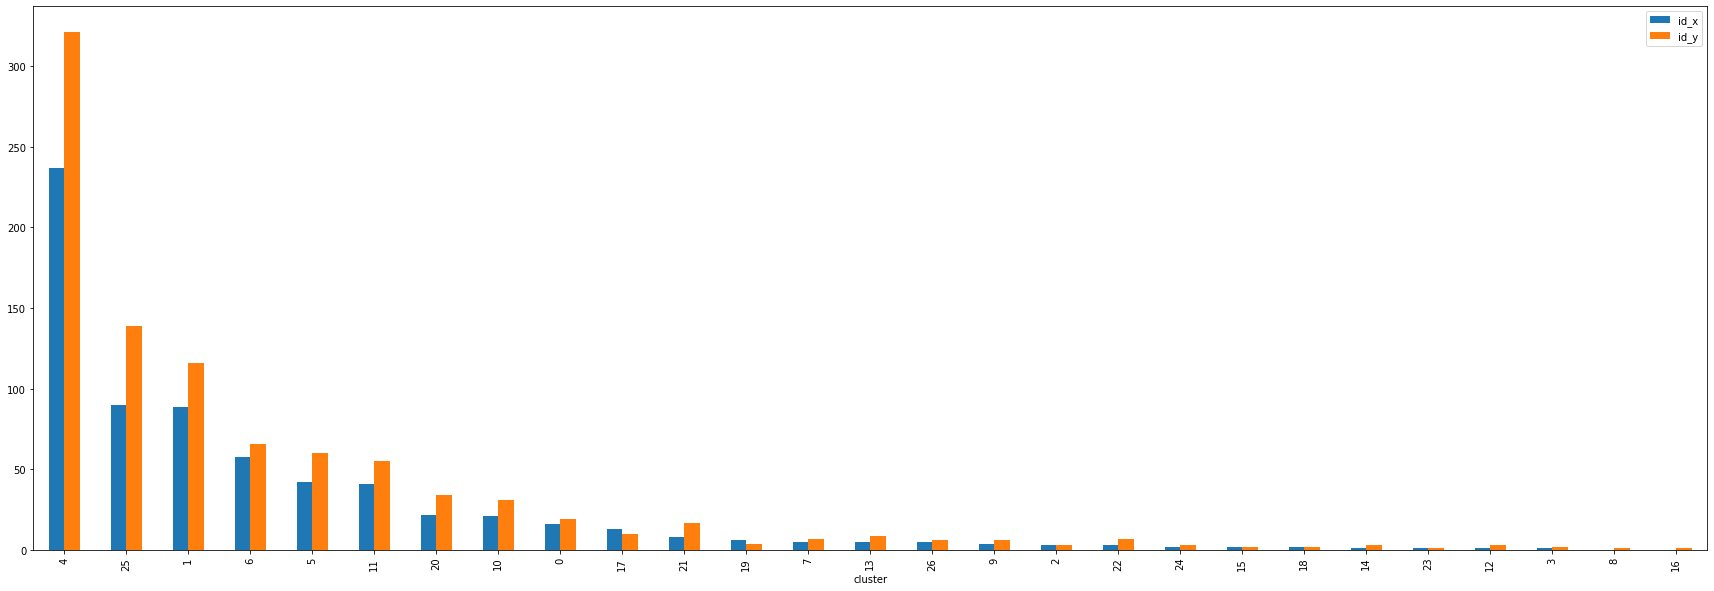

In [ ]:
loans_recom1 = df.iloc[np.unique(recom1),:]
loans_recom1 = loans_recom1.groupby('cluster')['id'].count()
loans_recom1 = pd.DataFrame(loans_recom1)
loans_recom1 = loans_recom1.reset_index('cluster')

loans_recom2 = df.iloc[np.unique(recom2),:]
loans_recom2 = loans_recom2.groupby('cluster')['id'].count()
loans_recom2 = pd.DataFrame(loans_recom2)
loans_recom2 = loans_recom2.reset_index('cluster')

loans_recom = pd.merge(loans_recom1,loans_recom2,on='cluster',how='outer').fillna(value=0)
loans_recom = loans_recom.sort_values('id_x', ascending=False)

loans_recom.plot.bar(x="cluster", y=["id_x", "id_y"],figsize=(30,10))

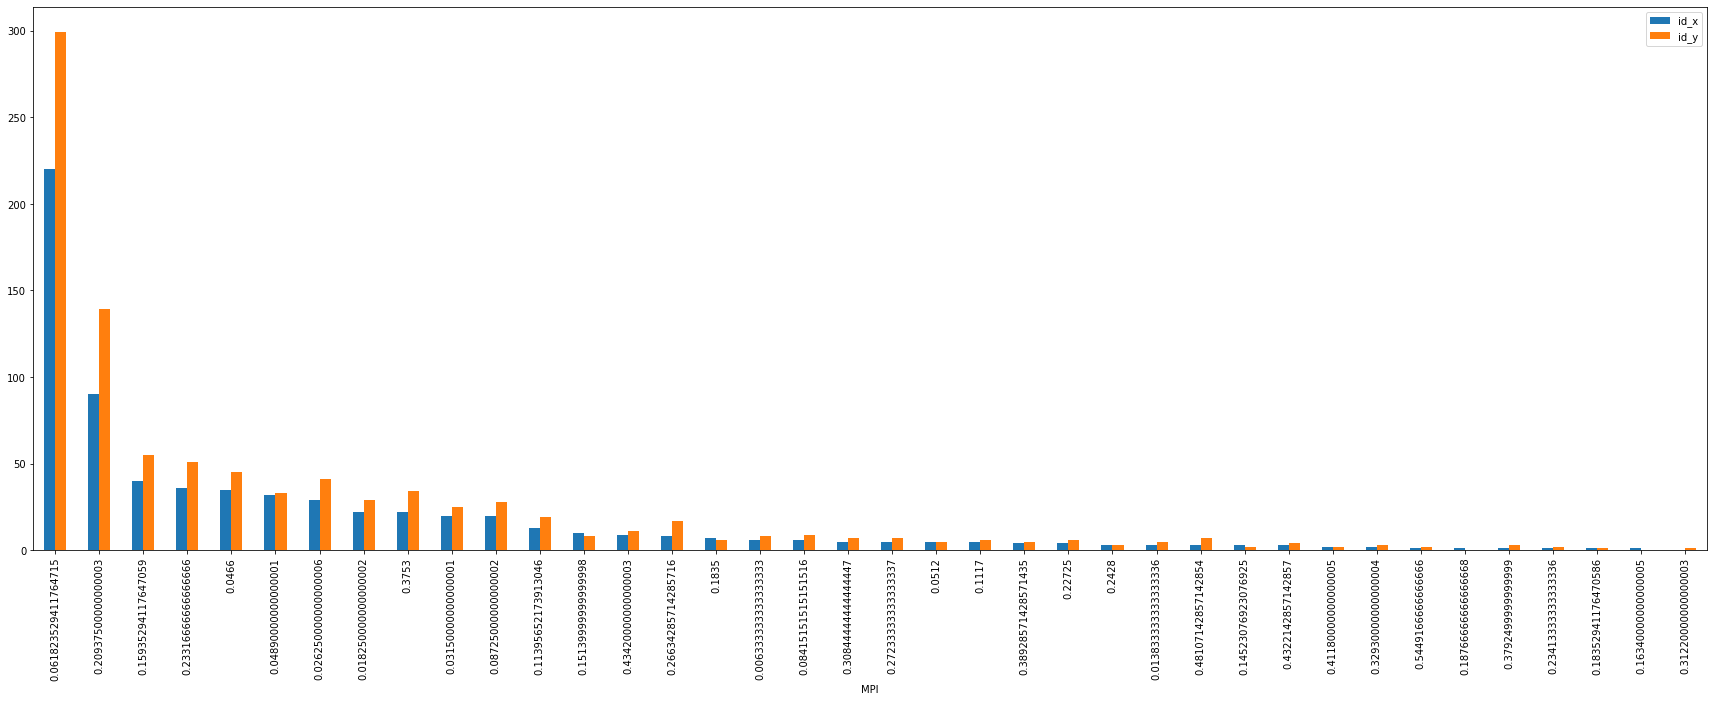

In [ ]:
loans_recom1 = df.iloc[np.unique(recom1),:]
loans_recom1 = loans_recom1.groupby('MPI')['id'].count()
loans_recom1 = pd.DataFrame(loans_recom1)
loans_recom1 = loans_recom1.reset_index('MPI')

loans_recom2 = df.iloc[np.unique(recom2),:]
loans_recom2 = loans_recom2.groupby('MPI')['id'].count()
loans_recom2 = pd.DataFrame(loans_recom2)
loans_recom2 = loans_recom2.reset_index('MPI')

loans_recom = pd.merge(loans_recom1,loans_recom2,on='MPI',how='outer').fillna(value=0)
loans_recom = loans_recom.sort_values('id_x', ascending=False)

loans_recom.plot.bar(x="MPI", y=["id_x", "id_y"],figsize=(30,10))

In [ ]:
loans_recom1 = loans_test.iloc[np.unique(recom1),:]

In [ ]:
recom1_gendertype=[]
for i in range(len(loans_recom1)):
  gen_split = loans_recom1.iloc[i,9].split(', ')
  if ('male' in gen_split) and ('female' in gen_split):
    recom1_gendertype.append('both')
  elif 'female' not in gen_split:
    recom1_gendertype.append('male')
  else:
    recom1_gendertype.append('female')

In [ ]:
loans_recom1['gender_type']=recom1_gendertype

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
loans_recom2 = loans_test.iloc[np.unique(recom2),:]
recom2_gendertype=[]
for i in range(len(loans_recom2)):
  gen_split = loans_recom2.iloc[i,9].split(', ')
  if ('male' in gen_split) and ('female' in gen_split):
    recom2_gendertype.append('both')
  elif 'female' not in gen_split:
    recom2_gendertype.append('male')
  else:
    recom2_gendertype.append('female')
loans_recom2['gender_type']=recom2_gendertype

In [ ]:

loans_recom1 = loans_recom1.groupby('gender_type')['id'].count()
loans_recom1 = pd.DataFrame(loans_recom1)
loans_recom1 = loans_recom1.reset_index('gender_type')


loans_recom2 = loans_recom2.groupby('gender_type')['id'].count()
loans_recom2 = pd.DataFrame(loans_recom2)
loans_recom2 = loans_recom2.reset_index('gender_type')

loans_recom = pd.merge(loans_recom1,loans_recom2,on='gender_type',how='outer').fillna(value=0)
loans_recom = loans_recom.sort_values('gender_type', ascending=True)


loans_recom.plot.bar(x="gender_type", y=["id_x", "id_y"],figsize=(30,10))

In [ ]:
loans_recom

,gender_type,id_x,id_y
0,both,75,75
1,female,824,805
2,male,342,513


In [ ]:
loans_recom_c2 = loans_recom_c2.sort_values(by='id', ascending=False)
plt.figure(figsize=(30,11))
plt.bar(loans_recom_c2['country_code'], loans_recom_c2['id'])
plt.xticks(rotation = 75, fontsize=12)
plt.ylabel('Percentage of the Total Loans (%)',fontsize=10)
plt.savefig("sector_percentage.png", bbox_inches = "tight")

In [ ]:
loans_recom_c = loans_recom.groupby('country_code')['id'].count()/len(loans_recom)*100
loans_recom_c = pd.DataFrame(loans_recom_c)
loans_recom_c = loans_recom_c.reset_index('country_code')

loans_recom_c = loans_recom_c.sort_values(by='id', ascending=False)
#plt.figure(figsize=(12,11))
plt.bar(loans_recom_c['country_code'], loans_recom_c['id'])
plt.xticks(rotation = 75, fontsize=12)
plt.ylabel('Percentage of the Total Loans (%)',fontsize=10)
plt.savefig("sector_percentage.png", bbox_inches = "tight")

In [ ]:
loans_c = loans_new.groupby('country_code')['id'].count()/len(loans)*100
loans_c = pd.DataFrame(loans_c)
loans_c = loans_c.reset_index('country_code')

loans_c = loans_c.sort_values(by='id', ascending=False)
plt.figure(figsize=(30,11))
plt.bar(loans_c['country_code'], loans_c['id'])
plt.xticks(rotation = 75, fontsize=12)
plt.ylabel('Percentage of the Total Loans (%)',fontsize=10)
plt.savefig("sector_percentage.png", bbox_inches = "tight")

In [ ]:
x1 = 2*np.arange(len(loans_recom_c['country_code']))
x2 = 2*np.arange(len(loans_c['country_code']))
plt.figure(figsize=(30,10))
ax1 = plt.subplot(1,1,1)

w = 0.8
#plt.xticks(), will label the bars on x axis with the respective country names.
plt.xticks(x1+w/2, loans_recom_c['country_code'], rotation='vertical', fontsize=20)
ax1.bar(x1, loans_recom_c['id']/15)
plt.xticks(fontsize=12)
plt.ylabel('Percentage of the Total Loans (%)',fontsize=10)


plt.ylabel('Preference', fontsize=25)
plt.yticks(fontsize=25)
#The trick is to use two different axes that share the same x axis, we have used ax1.twinx() method.
ax2 = plt.subplot(1,1,1)
#We have calculated GDP by dividing gdpPerCapita to population.
#ax2.bar(loans_c['country_code'], loans_c['id'])
plt.xticks(x2, loans_c['country_code'], rotation='vertical', fontsize=20)
ax2.bar(x2+w, loans_c['id'])
plt.ylim(0,2)
plt.yticks(fontsize=25)
#Set the Y axis label as GDP.
#plt.ylabel('Preference')
#To set the legend on the plot we have used plt.legend()
#plt.legend([pop, gdp],['Without Fairness', 'With Fairness'],fontsize=30)
#To show the plot finally we have used plt.show().


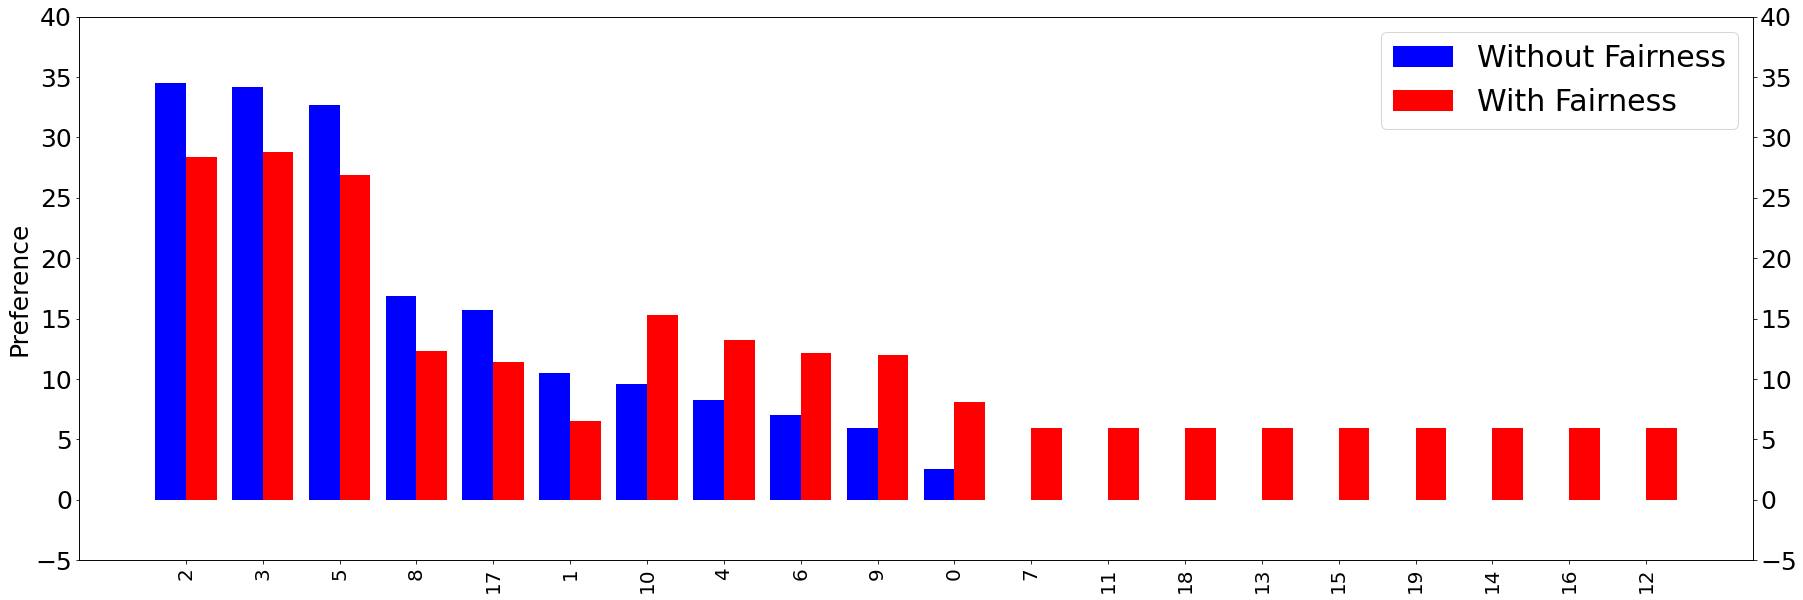

In [ ]:
pre_cluster1 = np.sum(X_cluster1.dot(Y_cluster1.T), axis = 0)
pre_cluster_sorted,pre_cluster1_sorted, items_cluster_sorted = zip(*sorted(zip(pre_cluster,pre_cluster1, items_cluster),reverse=True))

x = 2*np.arange(len(items_cluster_sorted))
plt.figure(figsize=(30,10))
ax1 = plt.subplot(1,1,1)

w = 0.8
#plt.xticks(), will label the bars on x axis with the respective country names.
plt.xticks(x+w/2, items_cluster_sorted, rotation='vertical', fontsize=20)
pop =ax1.bar(x, pre_cluster_sorted, width=w, color='b')
plt.ylim(-5,40)

plt.ylabel('Preference', fontsize=25)
plt.yticks(fontsize=25)
#The trick is to use two different axes that share the same x axis, we have used ax1.twinx() method.
ax2 = ax1.twinx()
#We have calculated GDP by dividing gdpPerCapita to population.
gdp =ax2.bar(x + w, pre_cluster1_sorted, width=w, color='r')
plt.ylim(-5,40)
plt.yticks(fontsize=25)
#Set the Y axis label as GDP.
#plt.ylabel('Preference')
#To set the legend on the plot we have used plt.legend()
plt.legend([pop, gdp],['Without Fairness', 'With Fairness'],fontsize=30)
#To show the plot finally we have used plt.show().
plt.savefig("after_fairness.png")

In [ ]:
m = len(users)
n = len(items_cluster)
f=5
lamda1 = 0.1
lamda2 = 3.0
X_cluster2 = np.copy(X_cluster)
Y_cluster2 = np.copy(Y_cluster)

K_cluster = 3.0*np.exp(p_cluster_est)

item_cluster_up_index = np.where(pre_cluster>0.3*np.max(pre_cluster))
INFO_cluster = np.ones((n,f))
INFO_cluster[item_cluster_up_index,:] = -1

max_iter = 1000
lost_cluster2 = [0]*max_iter
for k in range(max_iter):
    X_cluster2, Y_cluster2, l = ALS_FR4(X_cluster2, Y_cluster2, P_cluster, \
                                        C_cluster, K_cluster, alpha_cluster, lamda1, lamda2, m, n, f, INFO_cluster, 1.0e-7)
    lost_cluster2[k] = l

p_cluster_est2 = X_cluster2.dot(Y_cluster2.T)

In [ ]:
plt.plot(np.arange(max_iter),lost_cluster2,'b-')
plt.show()

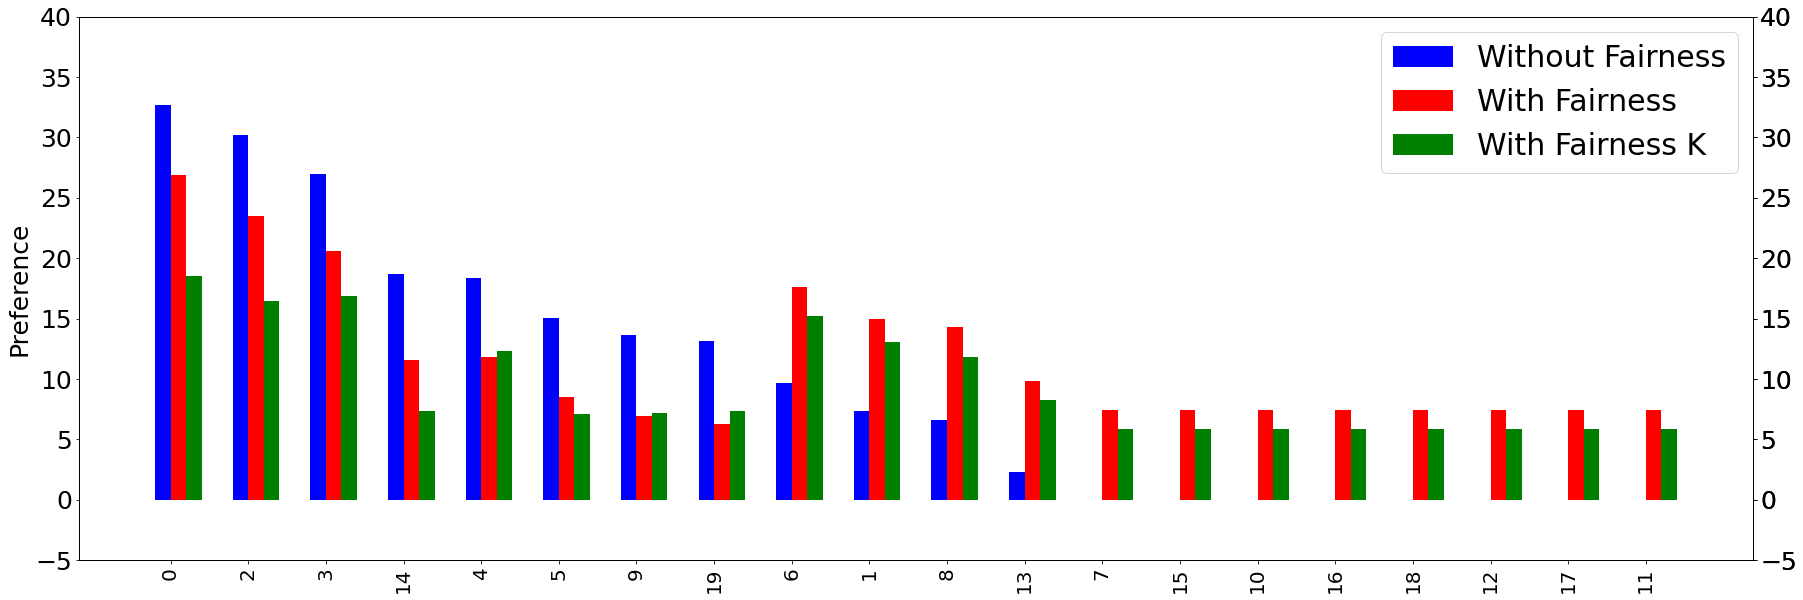

In [ ]:
pre_cluster2 = np.sum(X_cluster2.dot(Y_cluster2.T), axis = 0)
pre_cluster_sorted,pre_cluster1_sorted, pre_cluster2_sorted, items_cluster_sorted = zip(*sorted(zip(pre_cluster,pre_cluster1, pre_cluster2, items_cluster),reverse=True))

x = 2*np.arange(len(items_cluster_sorted))
plt.figure(figsize=(30,10))
ax1 = plt.subplot(1,1,1)

w = 0.4
#plt.xticks(), will label the bars on x axis with the respective country names.
plt.xticks(x+w/2, items_cluster_sorted, rotation='vertical', fontsize=20)
pop =ax1.bar(x, pre_cluster_sorted, width=w, color='b')
plt.ylim(-5,40)

plt.ylabel('Preference', fontsize=25)
plt.yticks(fontsize=25)
#The trick is to use two different axes that share the same x axis, we have used ax1.twinx() method.
ax2 = ax1.twinx()
#We have calculated GDP by dividing gdpPerCapita to population.
gdp1 =ax2.bar(x + w, pre_cluster1_sorted, width=w, color='r')
plt.ylim(-5,40)
plt.yticks(fontsize=25)
#Set the Y axis label as GDP.
#plt.ylabel('Preference')
#To set the legend on the plot we have used plt.legend()
ax3 = ax1.twinx()
#We have calculated GDP by dividing gdpPerCapita to population.
gdp2 =ax3.bar(x + 2*w, pre_cluster2_sorted, width=w, color='g')
plt.ylim(-5,40)
plt.yticks(fontsize=25)

plt.legend([pop, gdp1, gdp2],['Without Fairness', 'With Fairness', "With Fairness K"],fontsize=30)
#To show the plot finally we have used plt.show().
plt.savefig("after_fairness.png")



## Hierarchical Clustering

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage, set_link_color_palette, fcluster, fclusterdata

In [ ]:
import scipy.cluster.hierarchy as sch

In [ ]:
pip install hdbscan

In [ ]:
import hdbscan

In [ ]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=20, gen_min_span_tree=True)
clusterer.fit(enc_final)

In [ ]:
test_labels, strengths = hdbscan.approximate_predict(clusterer2, enc_final)

In [ ]:
np.unique(test_labels)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26])

In [ ]:
hdbscan.approximate_predict(clusterer, enc_final[0,:])

In [ ]:
clusterer2 = hdbscan.HDBSCAN(min_cluster_size=200, prediction_data=True).fit(enc_final)

In [ ]:
b1 = linkage(enc_final[0:100,:], metric="hamming")

In [ ]:
b

array([[0.00000000e+00, 9.00000000e+00, 0.00000000e+00, 2.00000000e+00],
       [1.00000000e+01, 1.00000000e+03, 0.00000000e+00, 3.00000000e+00],
       [1.20000000e+01, 1.00100000e+03, 0.00000000e+00, 4.00000000e+00],
       ...,
       [1.98200000e+03, 1.99500000e+03, 5.47945205e-02, 9.97000000e+02],
       [8.66000000e+02, 1.99600000e+03, 5.47945205e-02, 9.98000000e+02],
       [1.98300000e+03, 1.99700000e+03, 5.47945205e-02, 1.00000000e+03]])

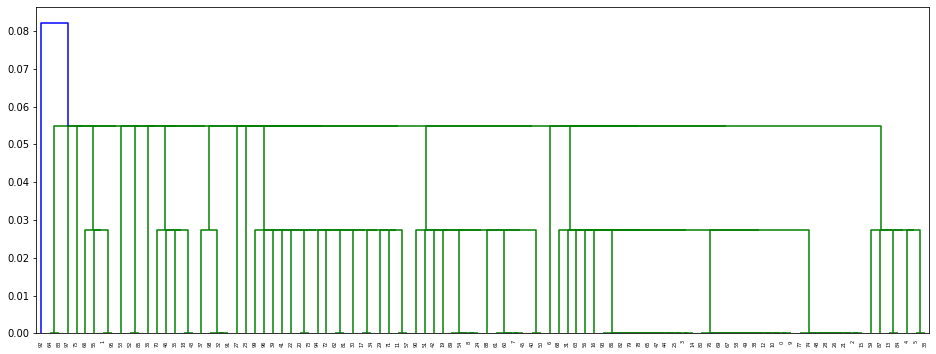

In [ ]:
#plt.figure(figsize=(12,10))
#d = dendrogram(b)
#plt.show()
#set_link_color_palette(['m', 'c', 'y', 'k'])
#fig, axes = plt.subplots(2, 1, figsize=(16, 6))
plt.figure(figsize=(16,6))
dn1 = dendrogram(b1)
#dn1 = dendrogram(b1, ax=axes[0], above_threshold_color='y', orientation='top')
#dn2 = dendrogram(Z, ax=axes[1], above_threshold_color='#bcbddc', orientation='right')
#set_link_color_palette(None)  # reset to default after use
plt.show()

In [ ]:
b_cluster = fcluster(b1, 2)

In [ ]:
b_cluster

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [ ]:
bcluster=fclusterdata(enc_final, 20)

In [ ]:
np.unique(bcluster)

array([1], dtype=int32)

In [ ]:
from sklearn.cluster import SpectralClustering

In [ ]:
c = SpectralClustering(20, assign_labels="discretize").fit(enc_final)

In [ ]:
clabel = c.labels_
clabel.reshape((clabel.shape[0],1))
loans_cluster1 = loans_new
loans_cluster1['cluster_label']=clabel

In [ ]:
users = pd.unique(loans_new['partner_id'])
users = np.array(users, dtype= int)
users = np.sort(users)

items_cluster1 = pd.unique(loans_cluster1['cluster_label'])
items_cluster1 = np.array(items_cluster1)
items_cluster1 = np.sort(items_cluster1)

indexed_items_cluster1 = pd.DataFrame({'index_i':range(0,len(items_cluster1)), 'cluster_label':items_cluster1})
indexed_users = pd.DataFrame({'index_u':range(0,len(users)), 'partner_id':users})

cluster_df1 = loans_cluster1.join(indexed_items_cluster1.set_index('cluster_label'),on='cluster_label')
cluster_df1 = cluster_df1.join(indexed_users.set_index('partner_id'),on='partner_id')
cluster_df1 = cluster_df1.groupby(['index_i', 'index_u']).size().sort_values(ascending=False).reset_index(name='count').drop_duplicates(subset='index_u')

R_cluster1 = np.zeros((len(users),len(items_cluster1)))
item_cluster_index1 = np.array(cluster_df1[['index_i']])
user_cluster_index = np.array(cluster_df1[['index_u']])
count_cluster_ui1 = np.array(cluster_df1[['count']])
R_cluster1[user_cluster_index,item_cluster_index1] = count_cluster_ui1
alpha_cluster1 = np.sum(R_cluster1>0)/np.sum(R_cluster1==0)

m = len(users)
n = len(items_cluster1)
f=5
lamda = 0.1
X_cluster1 = np.ones((m,f))*0.5
Y_cluster1 = np.zeros((n,f))
P_cluster1 = np.zeros((m,n))
P_cluster1[user_cluster_index,item_cluster_index1] = 1.0
C_cluster1 = 1+alpha_cluster1*R_cluster1

max_iter = 50
lost_cluster1 = [0]*max_iter
for k in range(max_iter):
    X_cluster1, Y_cluster1, l = ALS(X_cluster1, Y_cluster1, P_cluster1, C_cluster1, alpha_cluster1, lamda, m, n, f)
    lost_cluster1[k] = l

p_cluster_est1 = X_cluster1.dot(Y_cluster1.T)

In [ ]:
iteration = np.arange(max_iter)
plt.plot(iteration+1,np.array(lost_cluster1),'bo-')
plt.xlabel('Iterations')
plt.ylabel('Objective Function Value')
plt.show()

pre_cluster1 = np.sum(X_cluster1.dot(Y_cluster1.T), axis = 0)
pre_cluster_sorted1,items_cluster_sorted1 = zip(*sorted(zip(pre_cluster1,items_cluster1),reverse=True))
items_label_sorted1 = []
for i in range(len(items_cluster_sorted1)):
  items_label_sorted1.append(str(items_cluster_sorted1[i]))

plt.figure(figsize=(5,5))
plt.xticks(rotation = 45)
plt.bar(items_label_sorted1, pre_cluster_sorted1)

In [ ]:
m = len(users)
n = len(items_cluster1)
f=5
lamda1 = 0.1
lamda2 = 3.0
X_cluster2 = np.copy(X_cluster1)
Y_cluster2 = np.copy(Y_cluster1)

item_cluster_up_index = np.where(pre_cluster1>0.3*np.max(pre_cluster1))
INFO_cluster = np.ones((n,f))
INFO_cluster[item_cluster_up_index,:] = -1

max_iter = 1000
lost_cluster2 = [0]*max_iter
for k in range(max_iter):
    X_cluster2, Y_cluster2, l = ALS_FR3(X_cluster2, Y_cluster2, P_cluster1, \
                                        C_cluster1, alpha_cluster1, lamda1, lamda2, m, n, f, INFO_cluster, 1.0e-7)
    lost_cluster2[k] = l

p_cluster_est2 = X_cluster2.dot(Y_cluster2.T)

In [ ]:
plt.plot(np.arange(max_iter),lost_cluster2,'b-')
plt.show()

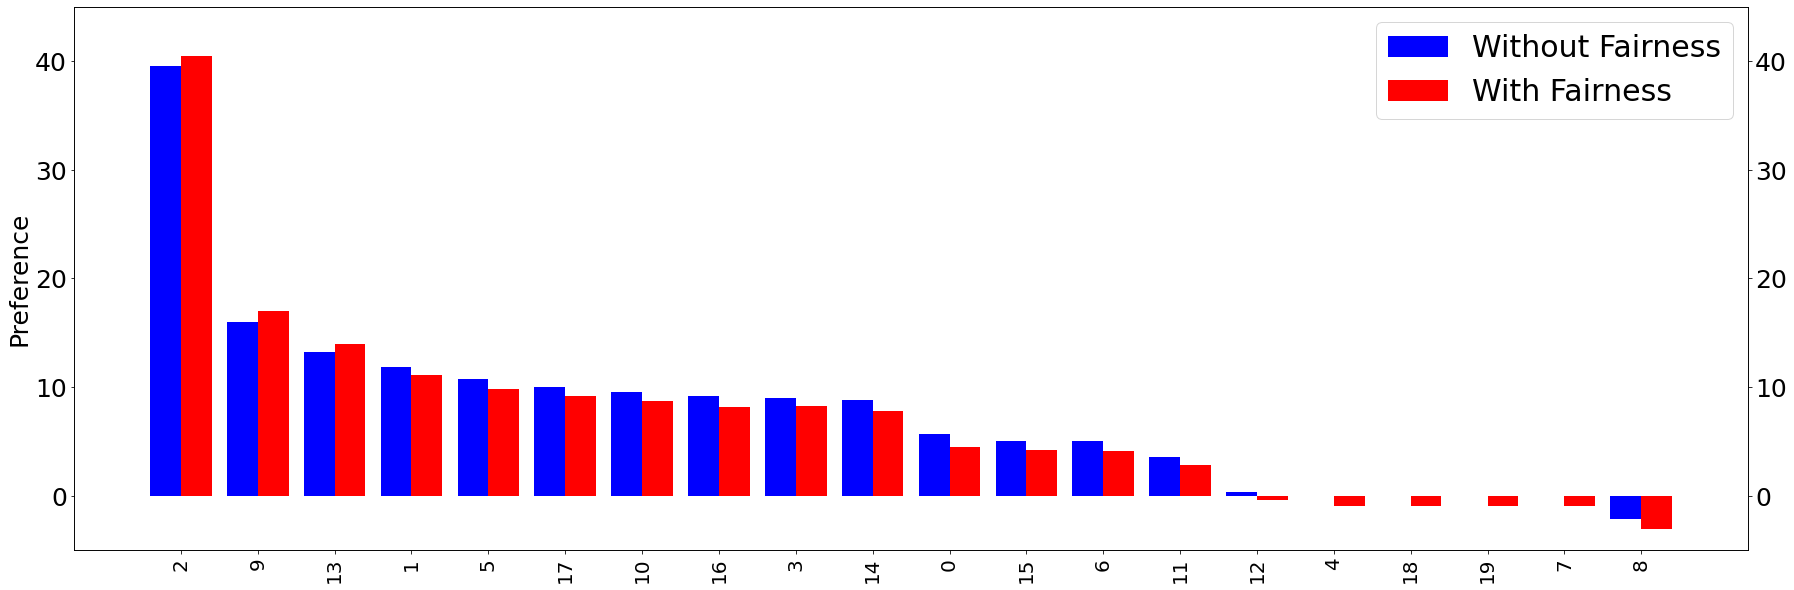

In [ ]:
pre_cluster2 = np.sum(X_cluster2.dot(Y_cluster2.T), axis = 0)
pre_cluster_sorted1,pre_cluster_sorted2, items_cluster_sorted1 = zip(*sorted(zip(pre_cluster1,pre_cluster2, items_cluster1),reverse=True))

x = 2*np.arange(len(items_cluster_sorted1))
plt.figure(figsize=(30,10))
ax1 = plt.subplot(1,1,1)

w = 0.8
#plt.xticks(), will label the bars on x axis with the respective country names.
plt.xticks(x+w/2, items_cluster_sorted1, rotation='vertical', fontsize=20)
pop =ax1.bar(x, pre_cluster_sorted1, width=w, color='b')
plt.ylim(-5,45)

plt.ylabel('Preference', fontsize=25)
plt.yticks(fontsize=25)
#The trick is to use two different axes that share the same x axis, we have used ax1.twinx() method.
ax2 = ax1.twinx()
#We have calculated GDP by dividing gdpPerCapita to population.
gdp =ax2.bar(x + w, pre_cluster_sorted2, width=w, color='r')
plt.ylim(-5,45)
plt.yticks(fontsize=25)
#Set the Y axis label as GDP.
#plt.ylabel('Preference')
#To set the legend on the plot we have used plt.legend()
plt.legend([pop, gdp],['Without Fairness', 'With Fairness'],fontsize=30)
#To show the plot finally we have used plt.show().
plt.savefig("after_fairness.png")

In [ ]:
m = len(users)
n = len(items_cluster1)
f=5
lamda1 = 0.1
lamda2 = 3.0
X_cluster3 = np.copy(X_cluster1)
Y_cluster3 = np.copy(Y_cluster1)

K_cluster = 3.0*np.exp(p_cluster_est1)

item_cluster_up_index = np.where(pre_cluster1>0.3*np.max(pre_cluster1))
INFO_cluster = np.ones((n,f))
INFO_cluster[item_cluster_up_index,:] = -1

max_iter = 5000
lost_cluster3 = [0]*max_iter
for k in range(max_iter):
    X_cluster3, Y_cluster3, l = ALS_FR4(X_cluster3, Y_cluster3, P_cluster1, \
                                        C_cluster1, K_cluster, alpha_cluster1, lamda1, lamda2, m, n, f, INFO_cluster, 1.0e-7)
    lost_cluster3[k] = l

p_cluster_est3 = X_cluster3.dot(Y_cluster3.T)

In [ ]:
max_iter = 30000
lost_cluster3 = [0]*max_iter
for k in range(max_iter):
    X_cluster3, Y_cluster3, l = ALS_FR4(X_cluster3, Y_cluster3, P_cluster1, \
                                        C_cluster1, K_cluster, alpha_cluster1, lamda1, lamda2, m, n, f, INFO_cluster, 1.0e-7)
    lost_cluster3[k] = l

p_cluster_est3 = X_cluster3.dot(Y_cluster3.T)

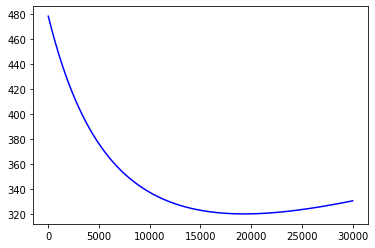

In [ ]:
plt.plot(np.arange(max_iter),lost_cluster3,'b-')
plt.show()

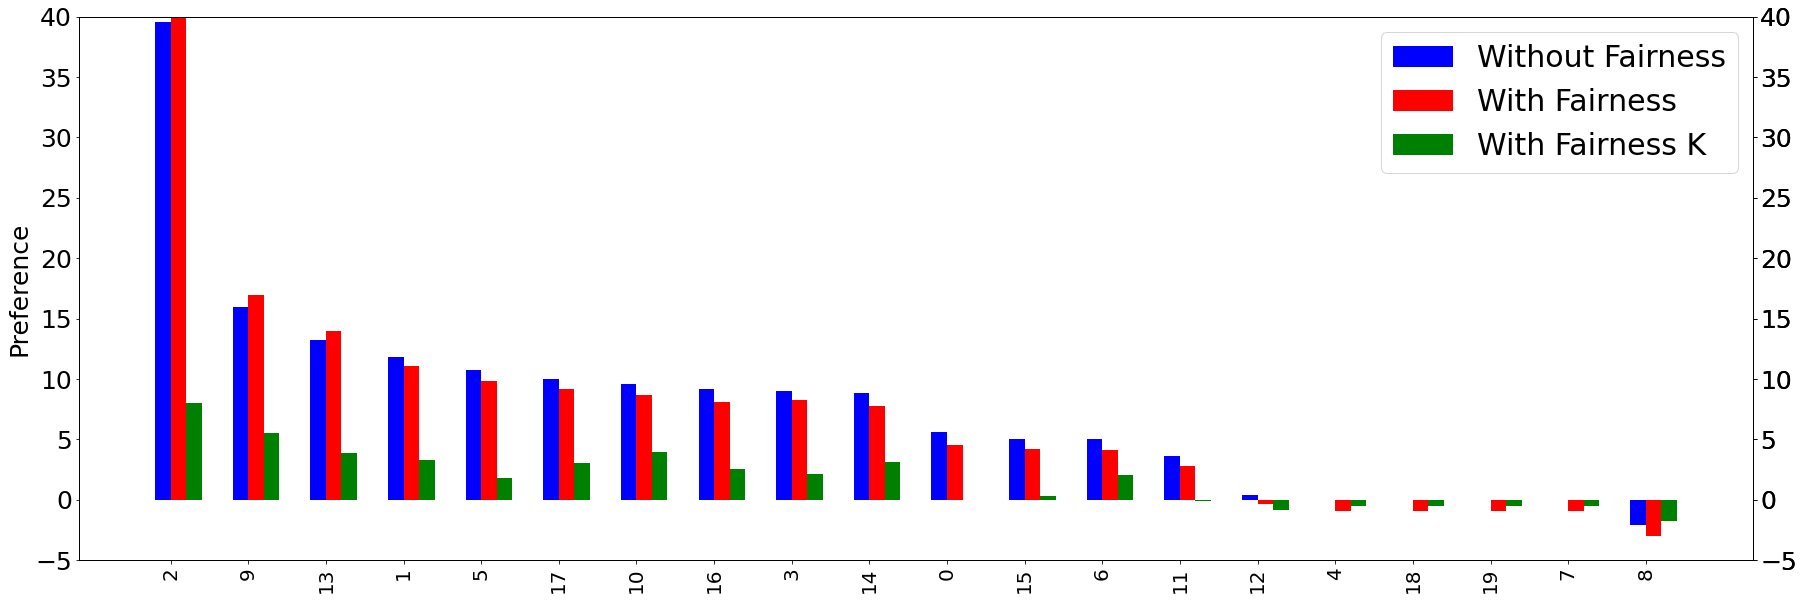

In [ ]:
pre_cluster3 = np.sum(X_cluster3.dot(Y_cluster3.T), axis = 0)
pre_cluster_sorted,pre_cluster1_sorted, pre_cluster2_sorted, items_cluster_sorted = zip(*sorted(zip(pre_cluster1,pre_cluster2, pre_cluster3, items_cluster1),reverse=True))

x = 2*np.arange(len(items_cluster_sorted))
plt.figure(figsize=(30,10))
ax1 = plt.subplot(1,1,1)

w = 0.4
#plt.xticks(), will label the bars on x axis with the respective country names.
plt.xticks(x+w/2, items_cluster_sorted, rotation='vertical', fontsize=20)
pop =ax1.bar(x, pre_cluster_sorted, width=w, color='b')
plt.ylim(-5,40)

plt.ylabel('Preference', fontsize=25)
plt.yticks(fontsize=25)
#The trick is to use two different axes that share the same x axis, we have used ax1.twinx() method.
ax2 = ax1.twinx()
#We have calculated GDP by dividing gdpPerCapita to population.
gdp1 =ax2.bar(x + w, pre_cluster1_sorted, width=w, color='r')
plt.ylim(-5,40)
plt.yticks(fontsize=25)
#Set the Y axis label as GDP.
#plt.ylabel('Preference')
#To set the legend on the plot we have used plt.legend()
ax3 = ax1.twinx()
#We have calculated GDP by dividing gdpPerCapita to population.
gdp2 =ax3.bar(x + 2*w, pre_cluster2_sorted, width=w, color='g')
plt.ylim(-5,40)
plt.yticks(fontsize=25)

plt.legend([pop, gdp1, gdp2],['Without Fairness', 'With Fairness', "With Fairness K"],fontsize=30)
#To show the plot finally we have used plt.show().
plt.savefig("after_fairness.png")